# Objective and Attribute Information
*Create a Machine learning application which predicts the estimated time and date for the final closure of a opened ticket based on the given attributes.*<br>

1. number: incident identifier (24,918 different values);
2. incident state: eight levels controlling the incident management process transitions from opening until closing the case;
3. active: boolean attribute that shows whether the record is active or closed/canceled;
4. reassignment_count: number of times the incident has the group or the support analysts changed;
5. reopen_count: number of times the incident resolution was rejected by the caller;
6. sys_mod_count: number of incident updates until that moment;
7. made_sla: boolean attribute that shows whether the incident exceeded the target SLA;
8. caller_id: identifier of the user affected;
9. opened_by: identifier of the user who reported the incident;
10. opened_at: incident user opening date and time;
11. sys_created_by: identifier of the user who registered the incident;
12. sys_created_at: incident system creation date and time;
13. sys_updated_by: identifier of the user who updated the incident and generated the current log record;
14. sys_updated_at: incident system update date and time;
15. contact_type: categorical attribute that shows by what means the incident was reported;
16. location: identifier of the location of the place affected;
17. category: first-level description of the affected service;
18. subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
19. u_symptom: description of the user perception about service availability;
20. cmdb_ci: (confirmation item) identifier used to report the affected item (not mandatory);
21. impact: description of the impact caused by the incident (values: 1Ã¢â‚¬â€œHigh; 2Ã¢â‚¬â€œMedium; 3Ã¢â‚¬â€œLow);
22. urgency: description of the urgency informed by the user for the incident resolution (values: 1Ã¢â‚¬â€œHigh; 2Ã¢â‚¬â€œMedium; 3Ã¢â‚¬â€œLow);
23. priority: calculated by the system based on 'impact' and 'urgency';
24. assignment_group: identifier of the support group in charge of the incident;
25. assigned_to: identifier of the user in charge of the incident;
26. knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
27. u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
28. notify: categorical attribute that shows whether notifications were generated for the incident;
29. problem_id: identifier of the problem associated with the incident;
30. rfc: (request for change) identifier of the change request associated with the incident;
31. vendor: identifier of the vendor in charge of the incident;
32. caused_by: identifier of the RFC responsible by the incident;
33. close_code: identifier of the resolution of the incident;
34. resolved_by: identifier of the user who resolved the incident;
35. resolved_at: incident user resolution date and time (dependent variable);
36. closed_at: incident user close date and time (dependent variable).

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import datetime as dt
from numba import njit
from scipy.stats import chisquare
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, hstack, csr_matrix
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from yellowbrick.classifier import roc_auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier
sns.set_style('dark')
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('incident_event_log.csv')
data.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [4]:
data.shape

(119998, 36)

In [9]:
data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

# Data Understanding

In [10]:
data.incident_state.unique()

array(['New', 'Resolved', 'Closed', 'Active', 'Awaiting User Info',
       'Awaiting Problem', 'Awaiting Vendor', 'Awaiting Evidence', '-100'],
      dtype=object)

In [3]:
data[data.incident_state=='-100'].shape

(2, 36)

In [18]:
data=data[data.incident_state!='-100']

In [19]:
data.incident_state.unique()

array(['New', 'Resolved', 'Closed', 'Active', 'Awaiting User Info',
       'Awaiting Problem', 'Awaiting Vendor', 'Awaiting Evidence'],
      dtype=object)

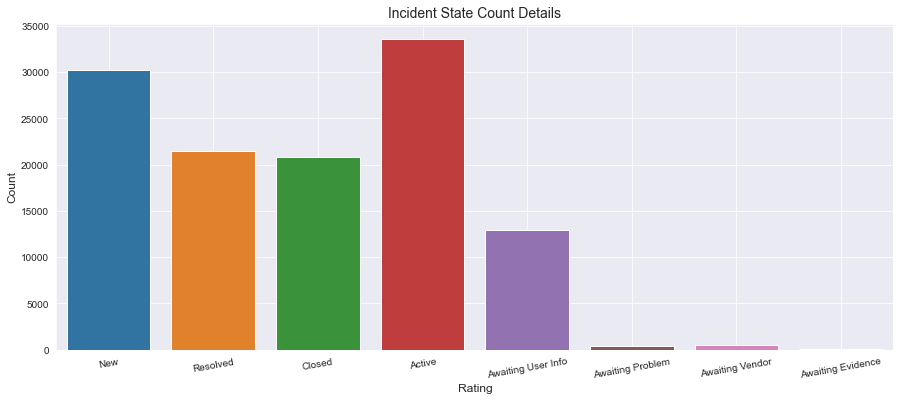

In [41]:
# Incident State
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['incident_state'],ax=ax)
plt.title("Incident State Count Details", size = 14)
plt.xlabel("Rating", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=10)
plt.grid()
plt.show()

In [20]:
# There are no duplicate values
data[data.duplicated()]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at


The Incident numbers are repetitive. Each time the Incident gets updated, it is considered as a new entry.<br>This would help us in estimating the resolution time from any given Incident.<br>However the Incident numbers are unique and cannot be considered as a feature in our model

In [22]:
# number
len(data.number.unique())

20769

In [47]:
data.number.value_counts().index[2000]

'INC0005744'

In [55]:
data[(data.number=='INC0005744')]['sys_mod_count'].shape

(11,)

In [54]:
data[(data.number=='INC0005744')]['sys_mod_count'].unique().shape

(11,)

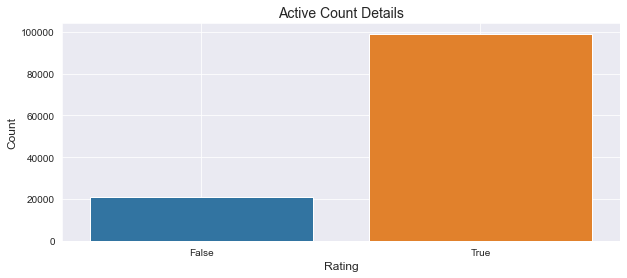

In [40]:
# active
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['active'],ax=ax)
plt.title("Active Count Details", size = 14)
plt.xlabel("Rating", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

As there are Incident entries for each update in the ticket, hence most of the entries shows as open Incident.

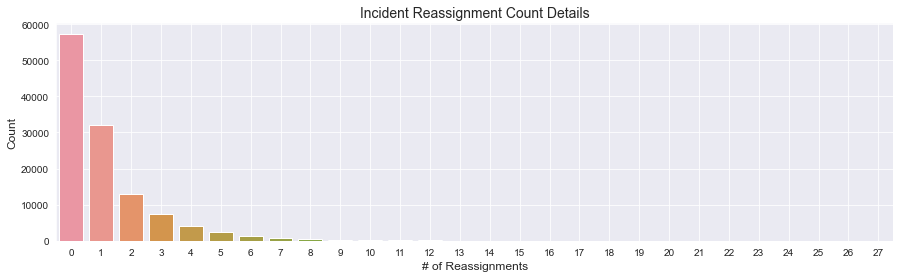

In [3]:
# reassignment_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['reassignment_count'],ax=ax)
plt.title("Incident Reassignment Count Details", size = 14)
plt.xlabel("# of Reassignments", size=12)
plt.ylabel("Count", size=12)
plt.grid()
plt.show()

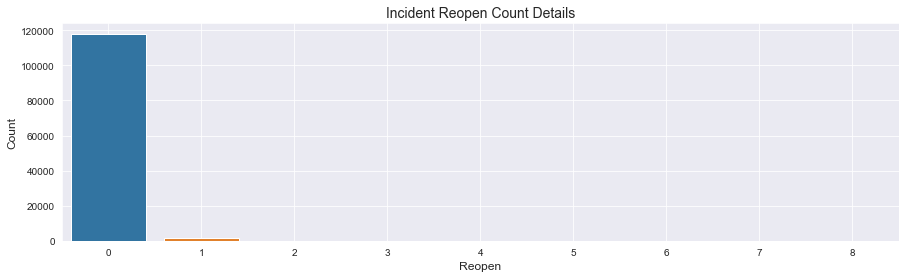

In [59]:
# 'reopen_count'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['reopen_count'],ax=ax)
plt.title("Incident Reopen Count Details", size = 14)
plt.xlabel("Reopen", size=12)
plt.ylabel("Count", size=12)
plt.grid()
plt.show()

For the most of the tickets has not been opened after the initial closure

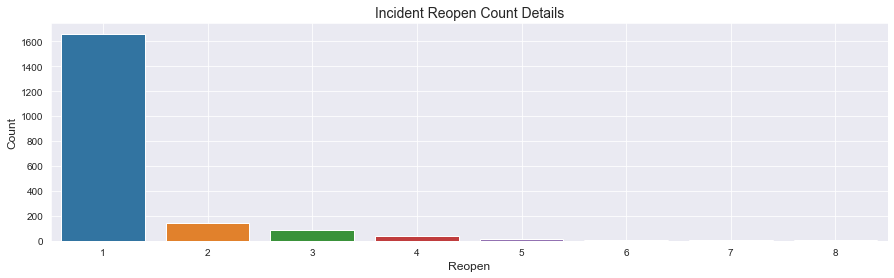

In [60]:
# 'reopen_count'
# Lets try to visualize the data without the '0'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data[data.reopen_count!=0]['reopen_count'],ax=ax)
plt.title("Incident Reopen Count Details", size = 14)
plt.xlabel("Reopen", size=12)
plt.ylabel("Count", size=12)
plt.grid()
plt.show()

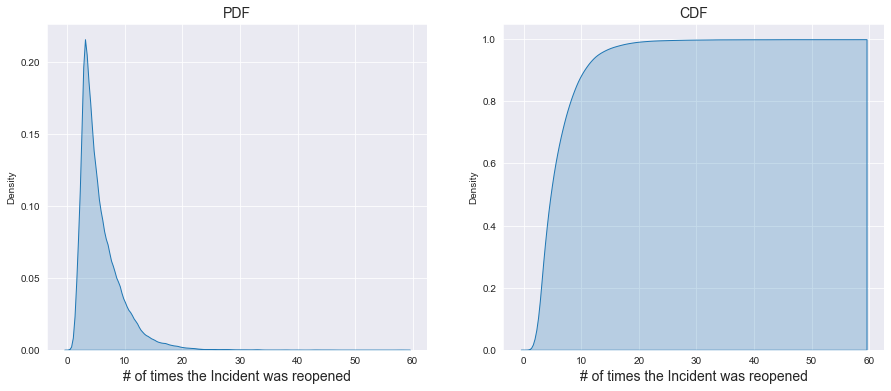

In [5]:
# Grouping the Incidents by wrt its reopen count
reass_cnt = data.groupby(by='number')['reopen_count'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.kdeplot(reass_cnt, shade=True, ax=ax1)
plt.xlabel('# of times the Incident was reopened',size = 14)
plt.title("PDF",size = 14)
ax1.grid()
ax2 = plt.subplot(122)
sns.kdeplot(reass_cnt, shade=True, cumulative=True,ax=ax2)
plt.xlabel('# of times the Incident was reopened',size = 14)
plt.title('CDF',size = 14)
ax2.grid()
plt.show()

Most of the Incidents has not been reopened.

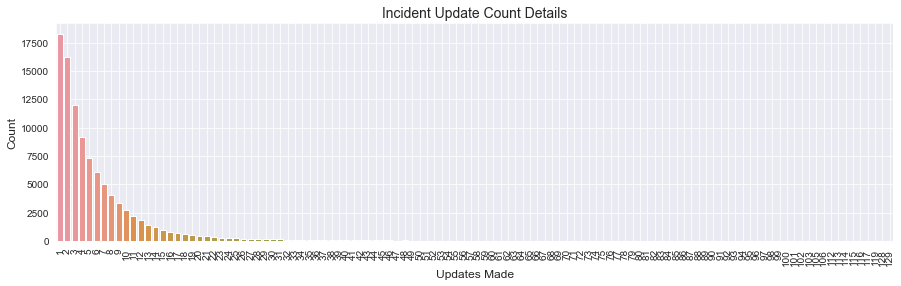

In [88]:
# 'sys_mod_count'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data[data.sys_mod_count>0]['sys_mod_count'],ax=ax)
plt.title("Incident Update Count Details", size = 14)
plt.xlabel("Updates Made", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

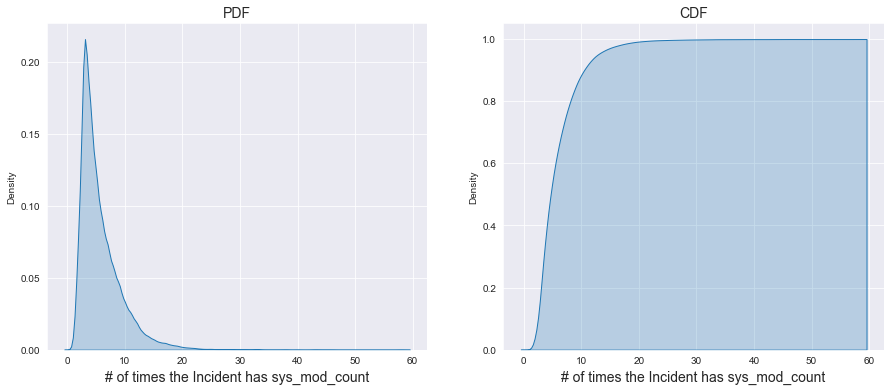

In [94]:
# Grouping the Incidents by wrt its sys_mod_count count
sys_mod_count_cnt = data.groupby(by='number')['sys_mod_count'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.kdeplot(sys_mod_count_cnt, shade=True, ax=ax1)
plt.xlabel('# of times the Incident has sys_mod_count',size = 14)
plt.title("PDF",size = 14)
ax1.grid()
ax2 = plt.subplot(122)
sns.kdeplot(sys_mod_count_cnt, shade=True, cumulative=True,ax=ax2)
plt.xlabel('# of times the Incident has sys_mod_count',size = 14)
plt.title('CDF',size = 14)
ax2.grid()
plt.show()

In [108]:
# made_sla
# Out of 20769 Incidents, 8174 Incidents have the SLA breached
print("Number of Incidents with SLA Breached", len(data[data.made_sla==False]['number'].unique()))
print(f"Percentage of Incidents with SLA Breached {len(data[data.made_sla==False]['number'].unique())/len(data.number.unique())*100} %")

Number of Incidents with SLA Breached 8174
Percentage of Incidents with SLA Breached 39.35673359333622 %


For any service Provider, this would be a grave concern.<br>Hence we need a model that can predict how long would a Incident would need to get resolved<br>With this data, we can focus on the Incidents which take longer time and take necessary steps to mitigate it, so that the company does not end up paying penalty

In [124]:
len(data['opened_by'].unique())

157

In [125]:
len(data['caller_id'].unique())

4829

In [142]:
data.opened_at = pd.to_datetime(data.opened_at)

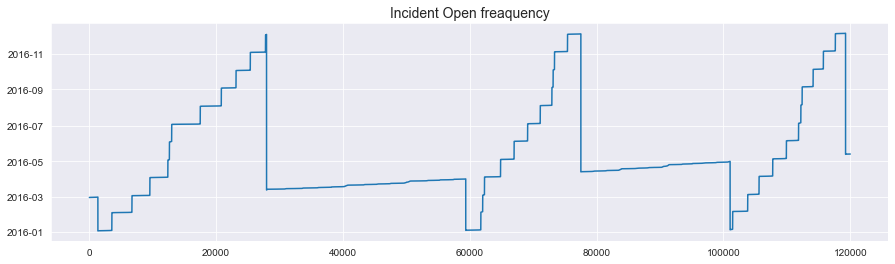

In [153]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
plt.plot(data['opened_at'])
plt.title("Incident Open freaquency", size = 14)
#plt.xlabel("Reopen", size=12)
#plt.ylabel("Count", size=12)
plt.grid()
plt.show()

In [160]:
data[data.sys_created_by=='?'].shape

(42354, 36)

In [7]:
# As we already have creted by, we will not need sys_created_by
data.drop('sys_created_by',axis =1,inplace=True)

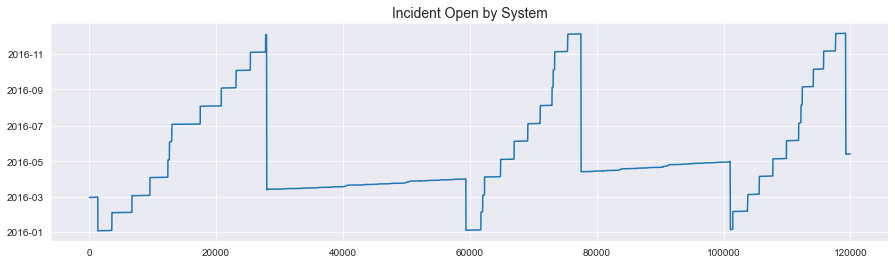

In [170]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
plt.plot(pd.to_datetime(data[data.sys_created_at!='?']['sys_created_at']))
plt.title("Incident Open by System", size = 14)
plt.grid()
plt.show()

In [8]:
# The distribution of the Inc created time in system and by user is same. Hence dropping system created time.
data.drop('sys_created_at',axis =1,inplace=True)

In [23]:
data["sys_updated_by"].str.split(pat=" ", expand=True)

,0,1,2
0,Updated,by,21
1,Updated,by,642
2,Updated,by,804
3,Updated,by,908
4,Updated,by,746
...,...,...,...
119993,Updated,by,44
119994,Updated,by,908
119995,Updated,by,908
119996,Updated,by,908


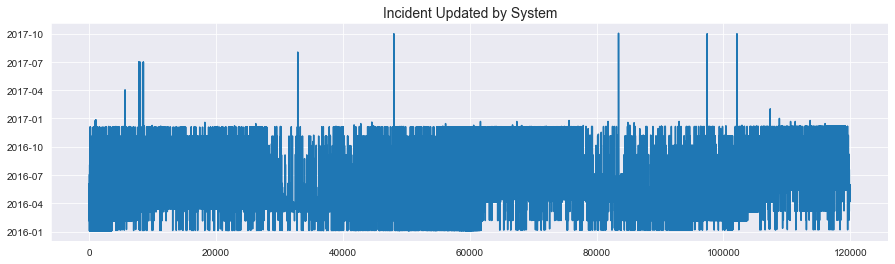

In [30]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
plt.plot(pd.to_datetime(data['sys_updated_at']))
plt.title("Incident Updated by System", size = 14)
plt.grid()
plt.show()

In [38]:
data['sys_updated_at'] = pd.to_datetime(data['sys_updated_at'])

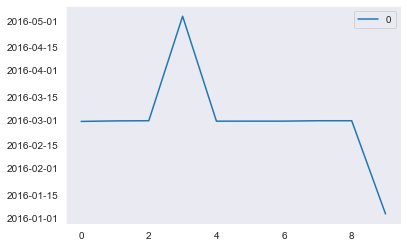

['2016-02-29T01:23:00.000000000' '2016-02-29T08:53:00.000000000'
 '2016-02-29T11:29:00.000000000' '2016-05-03T12:00:00.000000000'
 '2016-02-29T04:57:00.000000000' '2016-02-29T05:30:00.000000000'
 '2016-02-29T05:33:00.000000000' '2016-02-29T11:31:00.000000000'
 '2016-02-29T11:32:00.000000000' '2016-01-03T09:14:00.000000000']


In [57]:
pd.DataFrame(np.array(data['sys_updated_at'])[:10]).plot()
plt.show()
print(np.array(data['sys_updated_at'])[:10])

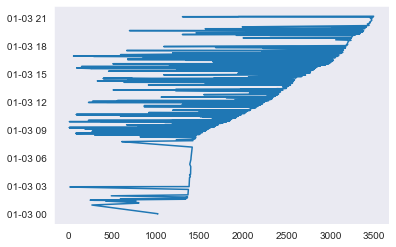

Timestamp('2016-01-03 21:07:00')

In [85]:
data.sort_values(by='sys_updated_at')['sys_updated_at'][:750].plot()
plt.show()
list(data.sort_values(by='sys_updated_at')['sys_updated_at'][:750])[749]

The ticket update time is completely random.<br>There seems to be some 24X7 team working, as the ticket update has been done round the cock

In [9]:
data.drop('sys_updated_at',axis =1,inplace=True)

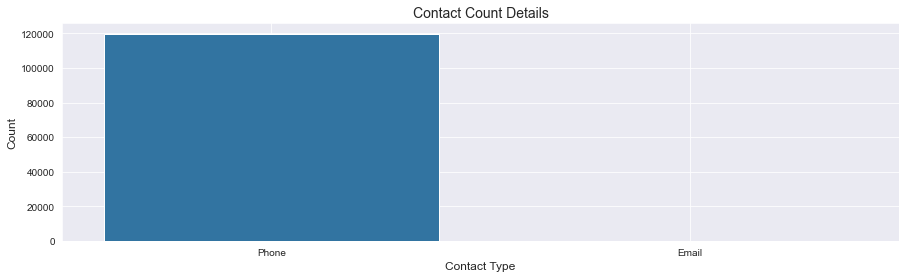

In [91]:
# 'contact_type'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['contact_type'],ax=ax)
plt.title("Contact Count Details", size = 14)
plt.xlabel("Contact Type", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

In [93]:
data['contact_type'].value_counts()

Phone    119879
Email       119
Name: contact_type, dtype: int64

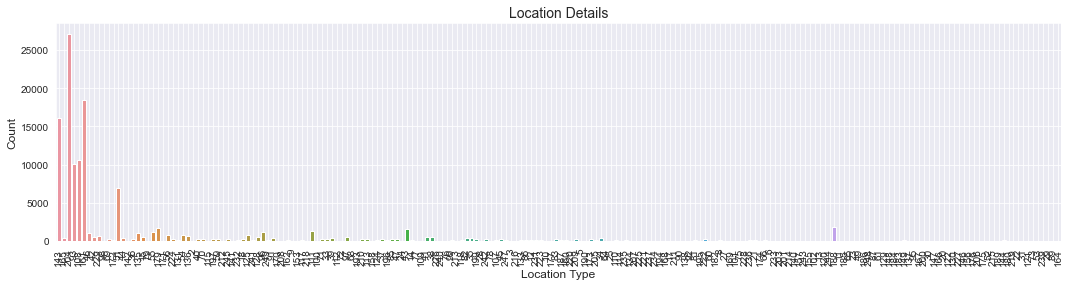

In [106]:
# 'location'
dd[['no','loc']]=data["location"].str.split(pat=" ", expand=True)
fig_dims = (18, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(dd['loc'],ax=ax)
plt.title("Location Details", size = 14)
plt.xlabel("Location Type", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

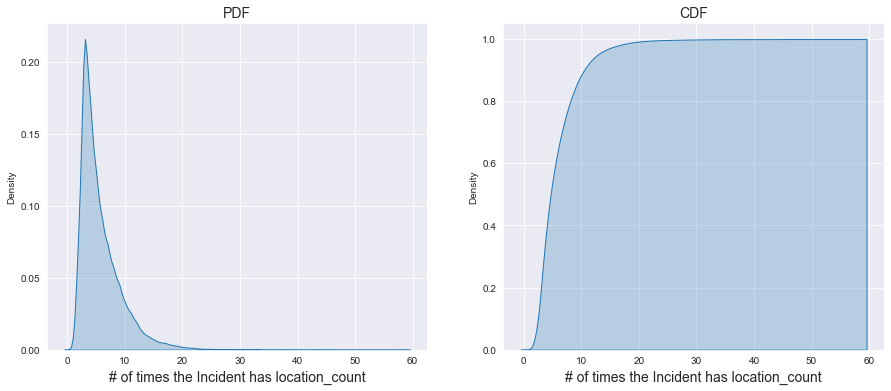

In [114]:
# Grouping the Incidents by wrt its sys_mod_count count
location_cnt = data.groupby(by='number')['location'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.kdeplot(location_cnt, shade=True, ax=ax1)
plt.xlabel('# of times the Incident has location_count',size = 14)
plt.title("PDF",size = 14)
ax1.grid()
ax2 = plt.subplot(122)
sns.kdeplot(location_cnt, shade=True, cumulative=True,ax=ax2)
plt.xlabel('# of times the Incident has location_count',size = 14)
plt.title('CDF',size = 14)
ax2.grid()
plt.show()

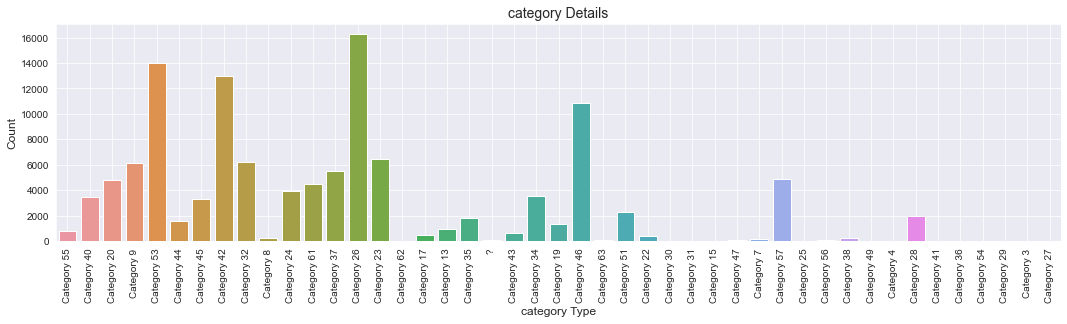

In [109]:
# 'category'
fig_dims = (18, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['category'],ax=ax)
plt.title("category Details", size = 14)
plt.xlabel("category Type", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

'?' Is a part of a categorical variable. Hence we can use them as a onehotencoded vectors

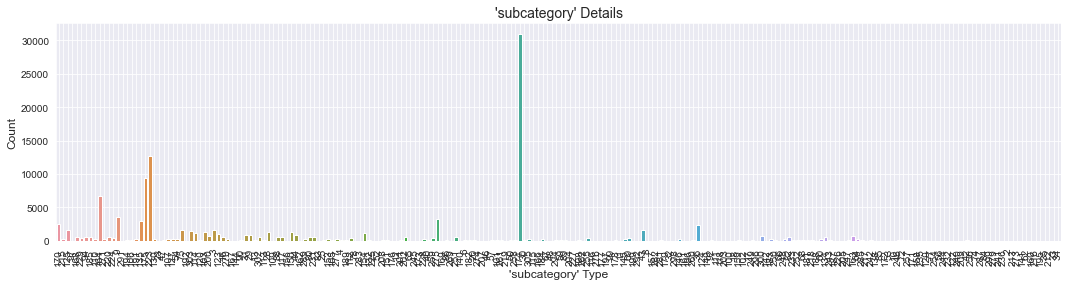

In [113]:
# 'subcategory'
dd[['no','sub']]=data["subcategory"].str.split(pat=" ", expand=True)
fig_dims = (18, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(dd['sub'],ax=ax)
plt.title("'subcategory' Details", size = 14)
plt.xlabel("'subcategory' Type", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

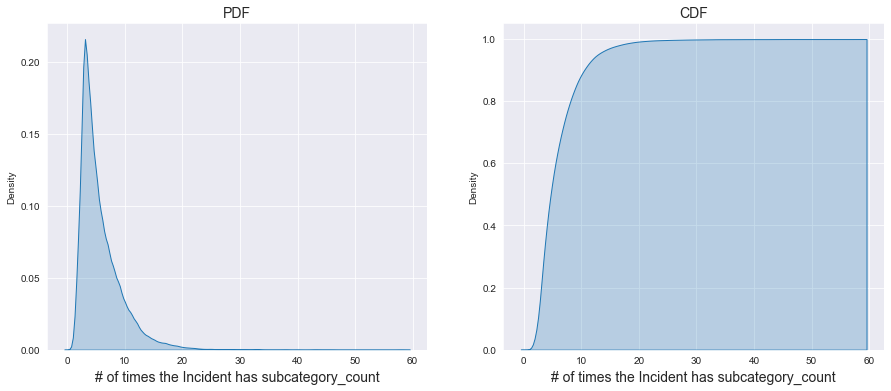

In [120]:
# Grouping the Incidents by wrt its sys_mod_count count
subcategory_cnt = data.groupby(by='number')['subcategory'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.kdeplot(subcategory_cnt, shade=True, ax=ax1)
plt.xlabel('# of times the Incident has subcategory_count',size = 14)
plt.title("PDF",size = 14)
ax1.grid()
ax2 = plt.subplot(122)
sns.kdeplot(subcategory_cnt, shade=True, cumulative=True,ax=ax2)
plt.xlabel('# of times the Incident has subcategory_count',size = 14)
plt.title('CDF',size = 14)
ax2.grid()
plt.show()

The PDF's shows that the categorical variables can be explained with few categories.

In [126]:
data[data.u_symptom=='?'].shape

(28271, 33)

In [127]:
data.u_symptom.value_counts()

Symptom 491    44412
?              28271
Symptom 534     4315
Symptom 4       2515
Symptom 387     2386
               ...  
Symptom 408        1
Symptom 578        1
Symptom 229        1
Symptom 172        1
Symptom 225        1
Name: u_symptom, Length: 500, dtype: int64

u_symptom: description of the user perception about service availability<br>This would have nothing to do with the actual incident resolution time.<br>Instead this would count when we need are working on end user satisfaction at ServiceDesk level.

In [129]:
data['cmdb_ci'].unique()

array(['?', 'cmdb_ci 31', 'cmdb_ci 23', 'cmdb_ci 22', 'cmdb_ci 6',
       'cmdb_ci 3', 'cmdb_ci 49', 'cmdb_ci 15', 'cmdb_ci 16',
       'cmdb_ci 19', 'cmdb_ci 48', 'cmdb_ci 14', 'cmdb_ci 28',
       'cmdb_ci 21', 'cmdb_ci 11', 'cmdb_ci 10', 'cmdb_ci 2', 'cmdb_ci 7',
       'cmdb_ci 5', 'cmdb_ci 12', 'cmdb_ci 35', 'cmdb_ci 26',
       'cmdb_ci 53', 'cmdb_ci 4', 'cmdb_ci 17', 'cmdb_ci 51',
       'cmdb_ci 33', 'cmdb_ci 36', 'cmdb_ci 13', 'cmdb_ci 27',
       'cmdb_ci 8', 'cmdb_ci 9', 'cmdb_ci 42', 'cmdb_ci 39', 'cmdb_ci 34',
       'cmdb_ci 24', 'cmdb_ci 46', 'cmdb_ci 47', 'cmdb_ci 41',
       'cmdb_ci 38', 'cmdb_ci 20', 'cmdb_ci 50', 'cmdb_ci 40',
       'cmdb_ci 18', 'cmdb_ci 37', 'cmdb_ci 45', 'cmdb_ci 32',
       'cmdb_ci 43', 'cmdb_ci 29'], dtype=object)

In [136]:
data[data.cmdb_ci=='?']['cmdb_ci'].value_counts().sum()/data.shape[0]*100
# Over 99% of the data is inconclusive for this. Hence we can ignore this

99.63666061101019

In [10]:
data.drop('cmdb_ci',axis =1,inplace=True)

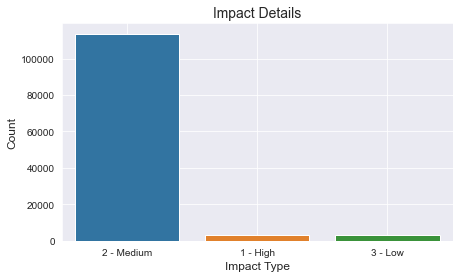

2 - Medium    113691
3 - Low         3418
1 - High        2889
Name: impact, dtype: int64

In [149]:
# 'impact' - This a very important field as based on this a service company calculates profit or penalty
# This plays a major role in our Incident resolution time as well
fig_dims = (7, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['impact'],ax=ax)
plt.title("Impact Details", size = 14)
plt.xlabel("Impact Type", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()
data['impact'].value_counts()

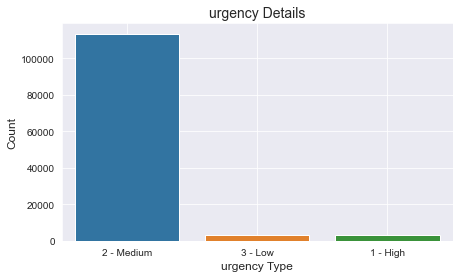

2 - Medium    113550
1 - High        3303
3 - Low         3145
Name: urgency, dtype: int64

In [148]:
# 'urgency' - This a very important field as based which the ticket is being handled
# This plays a major role in our Incident resolution time as well
fig_dims = (7, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['urgency'],ax=ax)
plt.title("urgency Details", size = 14)
plt.xlabel("urgency Type", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()
data['urgency'].value_counts()

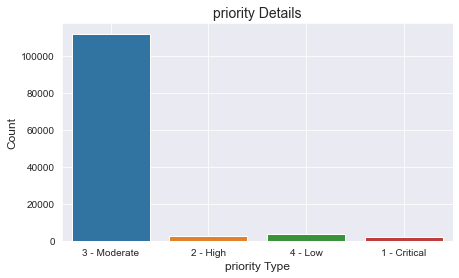

3 - Moderate    112115
4 - Low           3549
2 - High          2499
1 - Critical      1835
Name: priority, dtype: int64

In [150]:
# ''priority' - Combination of both Impact and urgency
# This plays a major role in our Incident resolution time as well
fig_dims = (7, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['priority'],ax=ax)
plt.title("priority Details", size = 14)
plt.xlabel("priority Type", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()
data['priority'].value_counts()

In [151]:
data['assignment_group'].value_counts()

Group 70    35023
?           14213
Group 25     6765
Group 24     5823
Group 20     5146
            ...  
Group 79        9
Group 80        6
Group 71        6
Group 4         1
Group 11        1
Name: assignment_group, Length: 73, dtype: int64

In [153]:
# We can drop Assignment group as if the Incident has been raised, initially it would be assigned to a certain group
# then transferred to appropriate group
# We can discard all the '?'
data[data.assignment_group=='?']['assignment_group'].value_counts().sum()/data.shape[0]*100

11.844364072734544

In [155]:
data['assigned_to'].value_counts()

?               23030
Resolver 17     10056
Resolver 13      7222
Resolver 194     2955
Resolver 57      2907
                ...  
Resolver 129        1
Resolver 67         1
Resolver 199        1
Resolver 146        1
Resolver 38         1
Name: assigned_to, Length: 209, dtype: int64

In [156]:
data[data.assigned_to=='?']['assigned_to'].value_counts().sum()/data.shape[0]*100

19.191986533108885

In [11]:
#As we are only want to predict the resolution time for the ticket resolution.
#We do not need these details
data.drop(['assignment_group', 'assigned_to'],axis=1,inplace=True)

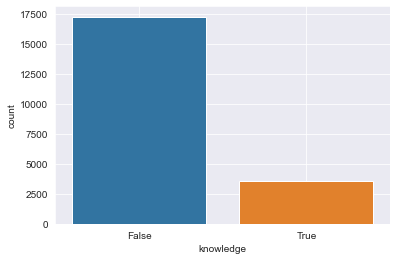

In [163]:
# Most of the tickets are coming in which are getting off the book resolutions
sns.countplot(data[data.incident_state=='Closed']['knowledge'])
plt.grid()
plt.show()

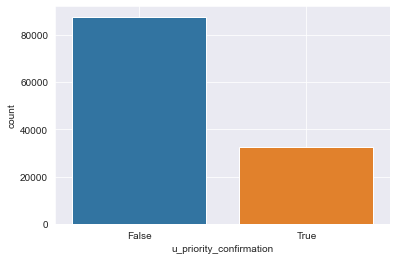

In [166]:
# Most of the tickets priority has not been changes.
# which means that the user got service soon enough
sns.countplot(data['u_priority_confirmation'])
plt.grid()
plt.show()

In [170]:
data['notify'].value_counts() # Almost for all the tickets notification has not been sent

Do Not Notify    119879
Send Email          119
Name: notify, dtype: int64

In [172]:
data['problem_id'].value_counts()

?                  118061
Problem ID  14        184
Problem ID  2         147
Problem ID  52         82
Problem ID  95         40
                    ...  
Problem ID  11          1
Problem ID  33          1
Problem ID  88          1
Problem ID  195         1
Problem ID  181         1
Name: problem_id, Length: 216, dtype: int64

In [12]:
# Most of the data is missing. Hence we can discard this
data.drop('problem_id',axis=1,inplace=True)

In [16]:
# This feature represents that if any change had been raised to get this resolved.
# For most of them change was ot raised
data['rfc'].value_counts()

?             119116
CHG0000132        20
CHG0001230        20
CHG0000047        18
CHG0001656        17
               ...  
CHG0000230         2
CHG0001437         1
CHG0001720         1
CHG0001829         1
CHG0000530         1
Name: rfc, Length: 163, dtype: int64

In [18]:
# For most of the tickets, vendor like Microsoft, ISP, Oracle was not approched
data['vendor'].value_counts()

?           119816
code 8s        137
Vendor 1        39
Vendor 3         4
Vendor 2         2
Name: vendor, dtype: int64

In [20]:
# Only two Incidents was caused due to change
data['caused_by'].value_counts()

?             119980
CHG0000097        11
CHG0000132         7
Name: caused_by, dtype: int64

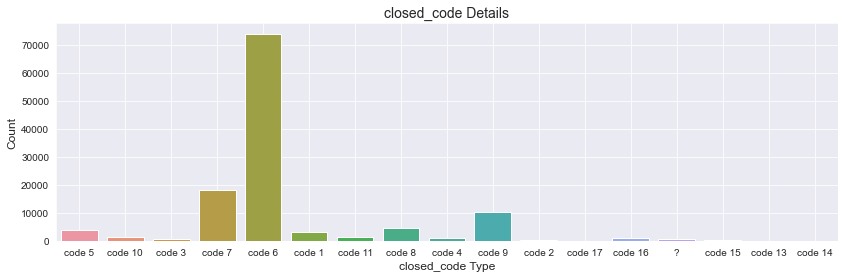

code 6     74039
code 7     18066
code 9     10187
code 8      4480
code 5      3863
code 1      3044
code 10     1455
code 11     1411
code 4       911
code 16      905
code 3       534
?            525
code 2       288
code 15      147
code 17       99
code 13       41
code 14        3
Name: closed_code, dtype: int64

In [24]:
# Incident closure details
fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['closed_code'],ax=ax)
plt.title("closed_code Details", size = 14)
plt.xlabel("closed_code Type", size=12)
plt.ylabel("Count", size=12)
plt.grid()
plt.show()
data['closed_code'].value_counts()

In [28]:
# Incident 'resolved_by' details
data['resolved_by'].value_counts()

Resolved by 15     14398
Resolved by 11      9864
Resolved by 53      3381
Resolved by 177     3226
Resolved by 62      3186
                   ...  
Resolved by 74         5
Resolved by 228        4
Resolved by 186        3
Resolved by 97         3
Resolved by 48         3
Name: resolved_by, Length: 191, dtype: int64

In [35]:
data.drop('resolved_by',axis=1,inplace=True)

In [33]:
data['closed_at']=pd.to_datetime(data['closed_at'])

# Data Preparation 

*Our objective is to predict a tentative time frame when a newly opened ticket would get*<br>For this we can pose this issue as a classification problem, which would predict different buckets of time frame withing which a newly created ticket is to get closed.<br>*We know that for a ticket to get closed, it takes another 5 days after a Incident has resolved*<br>Within this 5 days a user can reopen a ticket any time he/she wants.<br>*We also have to keep in mind that some of the features will not be available for any ticket which is initially opened.*<br>Also as a classification problem, we are to predict the day when the ticket is to be closed.<br>However we would also have the details on the issue for which the ticket had been raised.<br><br>For this we need to keep some of the features as well, as we would not be able to predict accurately and the objective is to notify the Manager whenever a ticket would have a potential to take up too muck time to resolve.

In [37]:
data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_updated_by', 'contact_type', 'location', 'category',
       'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_at', 'closed_at'],
      dtype='object')

*First we need to create our dependent variable*

In [149]:
data=pd.read_csv('incident_event_log.csv')
data.drop(['sys_created_by','sys_created_at','sys_updated_at','cmdb_ci','assignment_group', 'assigned_to','problem_id','resolved_by'],axis=1,inplace=True)

## Creating Target Variable

In [155]:
data['opened_at']=pd.to_datetime(data['opened_at'])
data['closed_at']=pd.to_datetime(data['closed_at'])
data['Difference'] = (data['closed_at'] - data['opened_at']).dt.days
data['Difference'] = np.array(data['Difference'])

In [159]:
# For some of the datapoints the open date is lrger than the closed data
# Which means the open date is later than the closed date
# usually we would just change the dates for that, but instead of doing so we would just change the negative sigh
# to a positive one, which would eventually fulfill the purpose of our dependent value creation
data['Difference'] = np.abs(data['Difference'])

In [162]:
np.sort(data['Difference'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 18

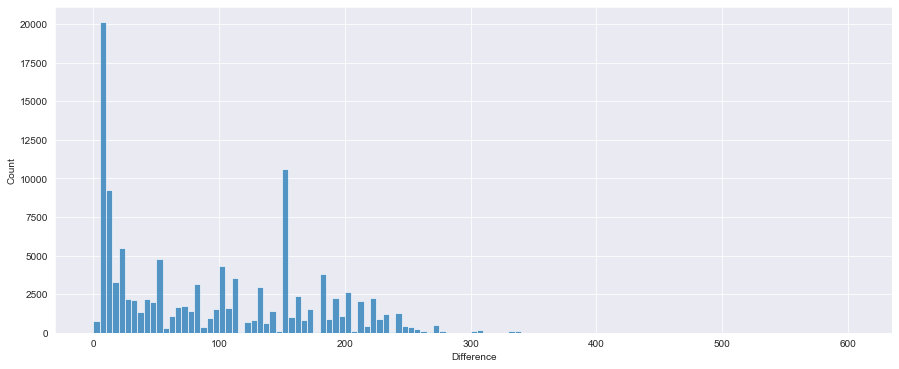

In [183]:
# Lets see the distribution of this dependent variable that we have created
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot((data['Difference']),binwidth=5)
plt.grid()
plt.show()

In Support Industry, it is highly irregular for an Incident to take up more than 5-10 days to resolve any Incident<br>
Usually the SLA clock runs only during the business hours which is 8.<br>
Hence as lets try to see the distribution by dividing the value by 8.<br>But the open and closed date only takes the date & time at that specific instance.

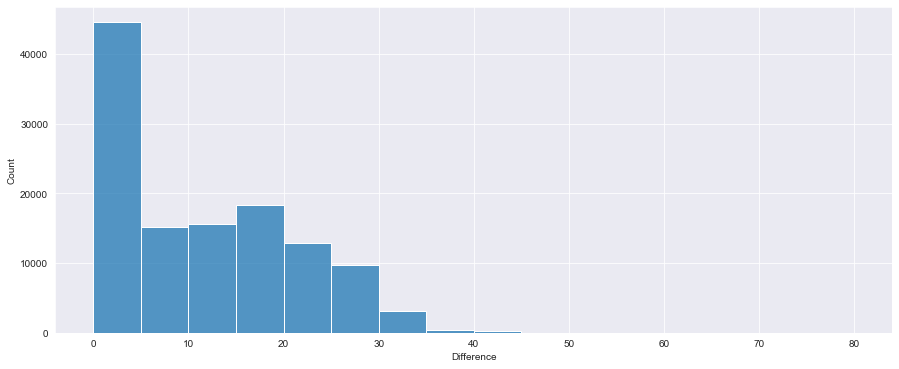

In [187]:
# Lets see the distribution of this dependent variable that we have created
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(np.abs((data['Difference'])/8),binwidth=5)
plt.grid()
plt.show()

Seeing the distribution we can say that the Industry standard SLA  are not maintained here.

In [199]:
np.sort(np.abs((data['Difference'])/8).astype(int).unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 41, 43, 53, 60, 63, 65, 69, 75])

We would create 5 classes<br>
- 0 to 4:- A
- 6 to 10:- B
- 11 to 20:- C
- 21 to 30:- D
- above 30:- E

In [201]:
data['Difference'] = np.abs((data['Difference'])/8).astype(int)

In [250]:
def cut(arr):
    bins = np.empty(arr.shape[0])
    for idx, x in enumerate(arr):
        if (x >= 0) & (x < 5):
            bins[idx] = 1
        elif (x >= 5) & (x < 11):
            bins[idx] = 2
        elif (x >= 11) & (x < 21):
            bins[idx] = 3
        elif (x >= 21) & (x < 31):
            bins[idx] = 4
        else:
            bins[idx] = 5
    return bins

In [252]:
data['Target'] = cut(data['Difference'].to_numpy())

In [254]:
data.to_pickle('data_1.pkl')

In [5]:
data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_updated_by', 'contact_type', 'location', 'category',
       'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_at', 'closed_at', 'Difference',
       'Target'],
      dtype='object')

**Lets drop columns which is not required**<br>
*Incident number will not play any role in predicting, as in the end we would have to predict for new Incidents*<br>
*CallerID, sys_updated_by and OpenedAt can be dropped:- The user can change*<br>
*'resolved_at', 'closed_at':- can be discarded, as well, as this would be the prediction that we would make*<br>
*need to create features from date, month seperately and create a new feature for day of the week from it*<br>

In [6]:
# 23.5 % of the data is missing for the u_symptom, which means that the user perception is not available
# We would replace it with 0, but as it is a categorical value, we do not need to specifically turn it into 0
# After onehotencoding it might be able to show it's some data of itself
data.u_symptom.value_counts()['?']/data.shape[0]*100

23.559559325988765

In [14]:
# RFC Suggests that there is some change that has been raised on this ticket
# Hence the '?' can be consdered as no change had been raised for the Incident
data.rfc.value_counts()['?']/data.shape[0]*100

99.26498774979584

In [21]:
# Similarly, the Incidnet did was not caused due to some change
# Hence '?' could be considered it as not caused due to change
data.caused_by.value_counts()['?']/data.shape[0]*100

99.98499974999582

In [23]:
data.closed_code.value_counts()['?']/data.shape[0]*100

0.4375072917881965

In [32]:
# Day of the week column, month and day
data['day_of_week'] = data['opened_at'].dt.day_name()
data['month'] = data['opened_at'].dt.month
data['day'] = data['opened_at'].dt.day

In [34]:
# dropping the features that will be required
data.drop(['caller_id','sys_updated_by','opened_at','resolved_at','closed_at'],axis=1,inplace=True)

In [39]:
# Lets not use the Incident numbers, as it would be new for a new one
print(len(data.number.unique()))
data.drop('number',axis=1,inplace=True)

20769


In [41]:
data.drop('Difference',axis=1,inplace=True)

In [43]:
# closed_code:- will not be available unless the Incident is closed, hence we can drop this feature as well
data.drop('closed_code',axis=1,inplace=True)
data.columns

Index(['incident_state', 'active', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'Target', 'day_of_week', 'month', 'day'],
      dtype='object')

In [45]:
data.to_pickle('Data_dropped_2.pkl')

# EDA

In [5]:
data=data[~(data.incident_state=='-100')]

In [6]:
data.columns

Index(['incident_state', 'active', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'Target', 'day_of_week', 'month', 'day', 'Difference'],
      dtype='object')

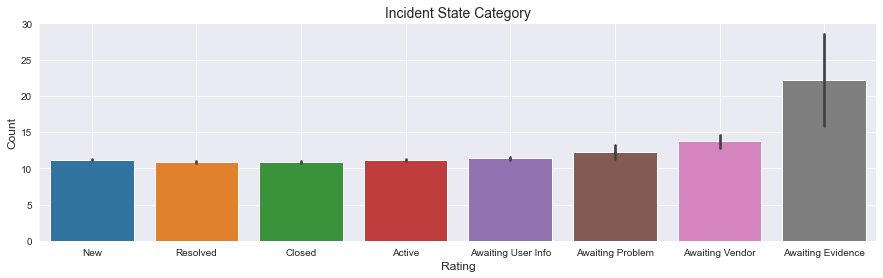

In [7]:
# incident_state
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'incident_state',y='Difference',ax=ax)
plt.title("Incident State Category", size = 14)
plt.xlabel("Rating", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

As seen in the plot, the state of 'Awaiting Evidence' requires much more resolution time than others

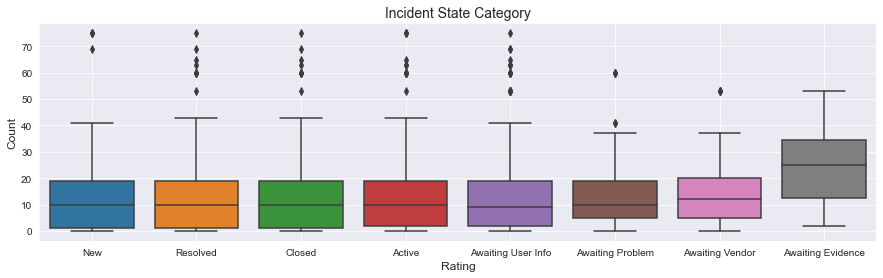

In [8]:
# incident_state
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'incident_state',y='Difference',ax=ax)
plt.title("Incident State Category", size = 14)
plt.xlabel("Rating", size=12)
plt.ylabel("Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

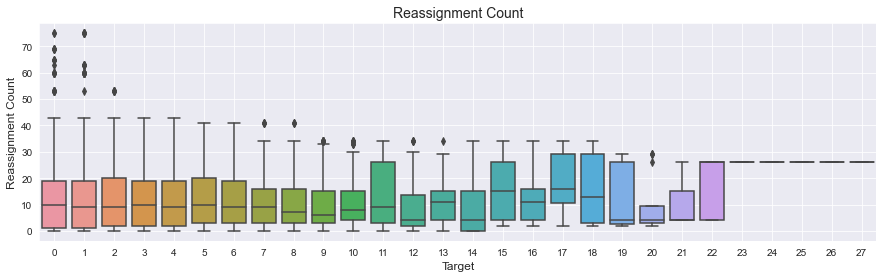

In [12]:
# reassignment_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'reassignment_count',y='Difference',ax=ax)
plt.title("Reassignment Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

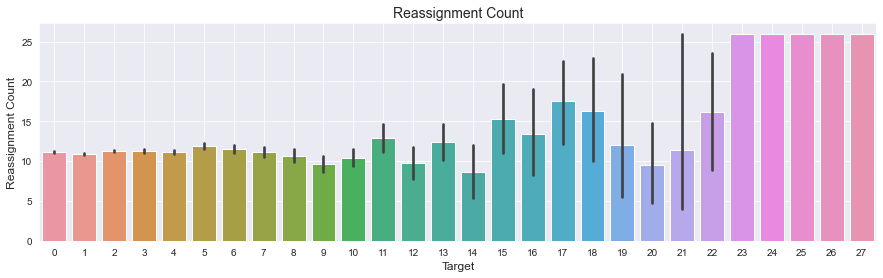

In [11]:
# reassignment_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'reassignment_count',y='Difference',ax=ax)
plt.title("Reassignment Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
#plt.xticks(rotation=10)
plt.grid()
plt.show()

reassignment_count:- As it has some separability, hence this feature will add to our classification model

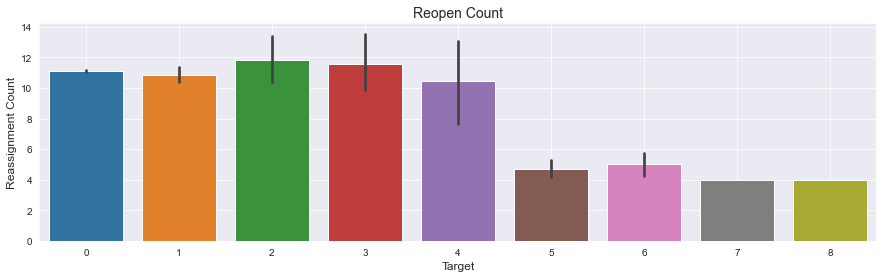

In [13]:
# reopen_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'reopen_count',y='Difference',ax=ax)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

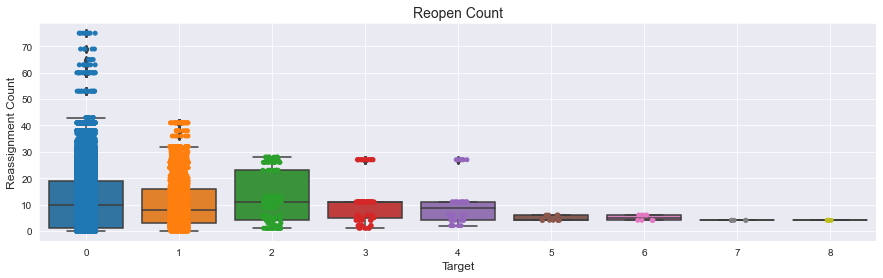

In [14]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,y= 'Difference',x='reopen_count',ax=ax)
sns.stripplot(data=data,y= 'Difference',x='reopen_count',ax=ax,jitter=True)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

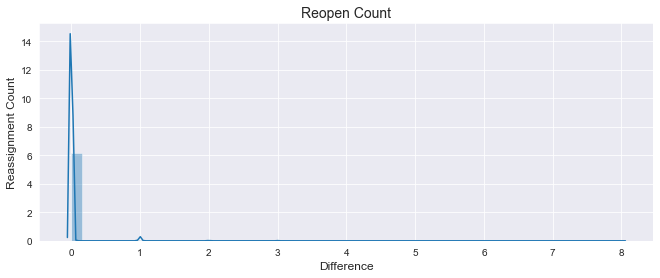

In [15]:
fig_dims = (11, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(data['reopen_count'])
plt.title("Reopen Count", size = 14)
plt.xlabel("Difference", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

reopen_count:- This feature as well, shows some form of separability.

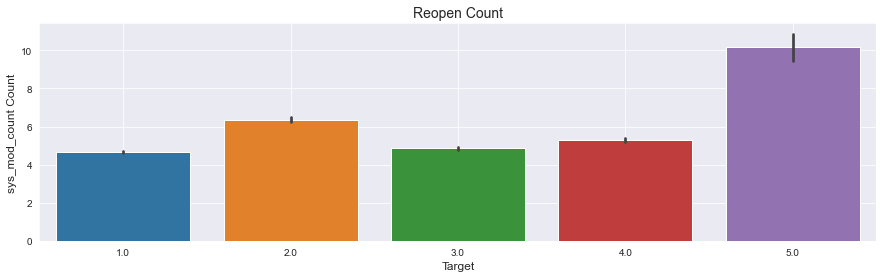

In [16]:
# sys_mod_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'Target',y='sys_mod_count',ax=ax)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("sys_mod_count Count", size=12)
plt.grid()
plt.show()

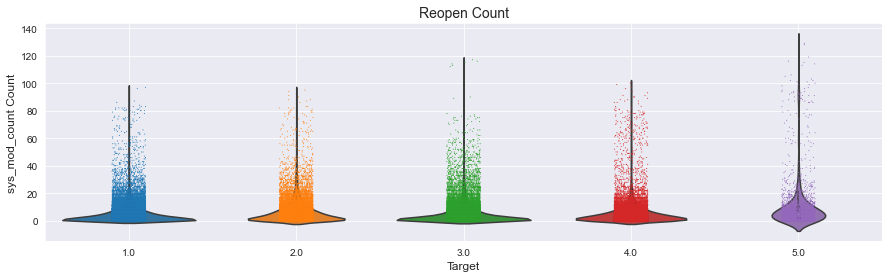

In [17]:
# sys_mod_count
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.violinplot(data=data,x= 'Target',y='sys_mod_count',ax=ax)
sns.stripplot(data=data,y= 'sys_mod_count',x='Target',ax=ax,jitter=True,size=1)
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("sys_mod_count Count", size=12)
plt.grid()
plt.show()

sys_mod_count:- Similarly to others this also shown some form of separability

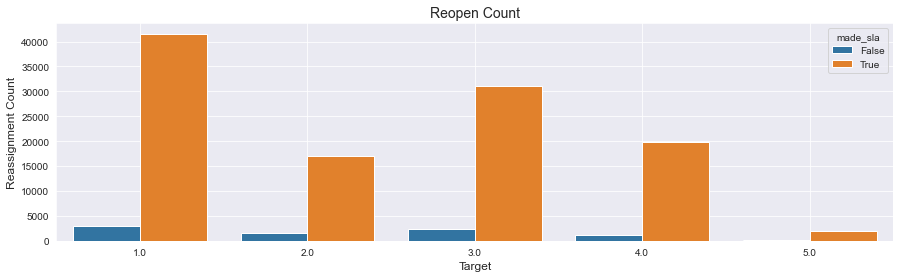

In [119]:
# made_sla
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data=data,x='Target',ax=ax,hue='made_sla')
plt.title("Reopen Count", size = 14)
plt.xlabel("Target", size=12)
plt.ylabel("Reassignment Count", size=12)
plt.grid()
plt.show()

made_sla:-<br>As seen here the Incidents which failed to maintain the SLA belongs to first category. However the tickets which take most time to get resolved are the ones breaching very SLA.<br>This is definitely not maintaining industry standard.<br>Hence we can assume that some of the types of Incidents have more SLA than others.

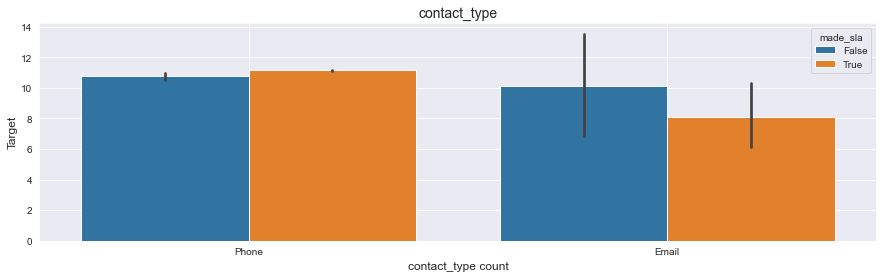

Phone    119877
Email       119
Name: contact_type, dtype: int64

In [18]:
# contact_type
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'contact_type',y='Difference',ax=ax,hue='made_sla')
plt.title("contact_type", size = 14)
plt.xlabel("contact_type count", size=12)
plt.ylabel("Target", size=12)
plt.grid()
plt.show()
data.contact_type.value_counts()

Although the Incidents raised by the Phone is much more than that of Email. We see that both the categories covers almost similar categories w.r.t our Target variable

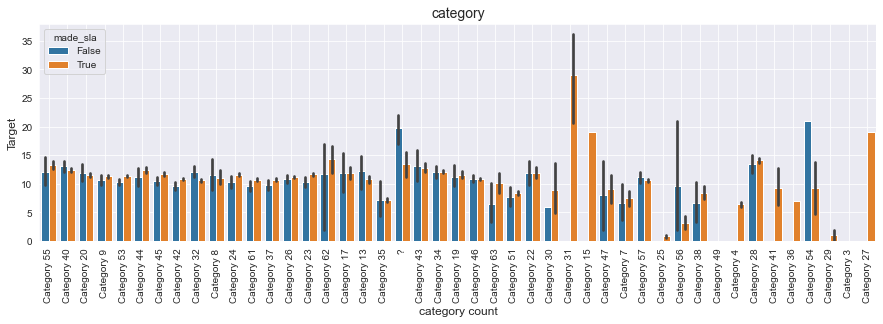

In [19]:
# category
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'category',y='Difference',ax=ax,hue='made_sla')
plt.title("category", size = 14)
plt.xlabel("category count", size=12)
plt.ylabel("Target", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

As observed before, the SLA for the tickets that took most time to get closed are compliant.

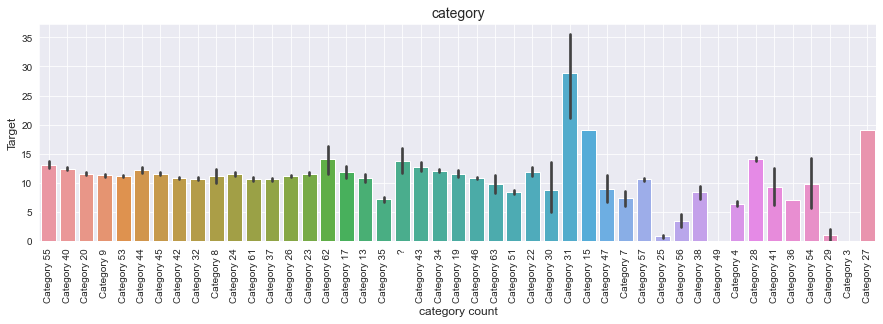

In [20]:
# category
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'category',y='Difference',ax=ax)#,hue='made_sla')
plt.title("category", size = 14)
plt.xlabel("category count", size=12)
plt.ylabel("Target", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

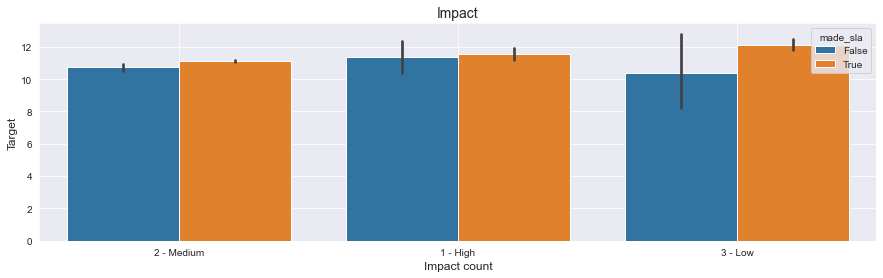

In [21]:
# impact
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'impact',y='Difference',ax=ax,hue='made_sla')
plt.title("Impact", size = 14)
plt.xlabel("Impact count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

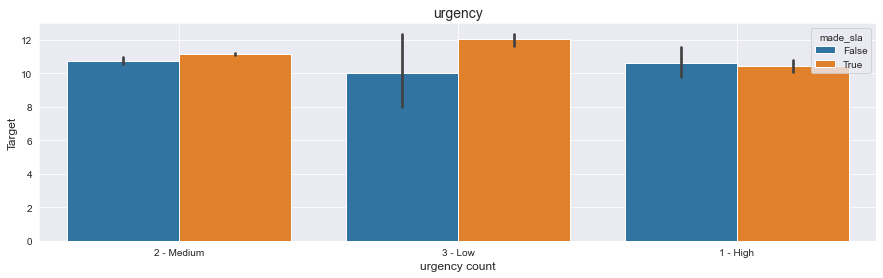

In [22]:
# urgency
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'urgency',y='Difference',ax=ax,hue='made_sla')
plt.title("urgency", size = 14)
plt.xlabel("urgency count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

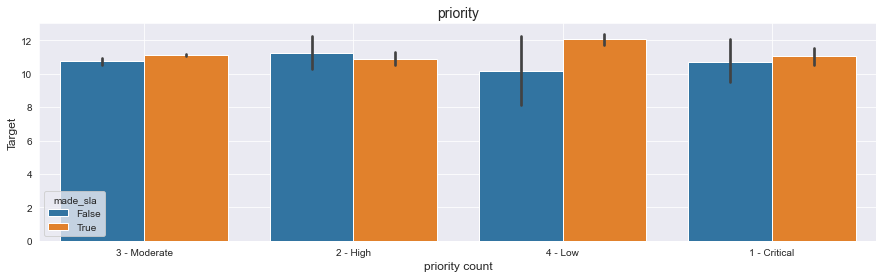

In [23]:
# priority
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'priority',y='Difference',ax=ax,hue='made_sla')
plt.title("priority", size = 14)
plt.xlabel("priority count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

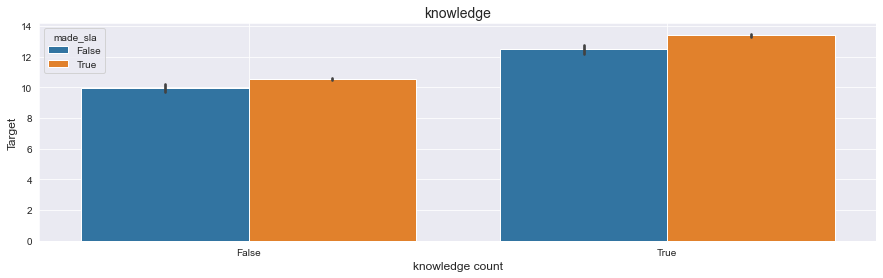

In [28]:
# 'knowledge'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'knowledge',y='Difference',ax=ax,hue='made_sla')
plt.title("knowledge", size = 14)
plt.xlabel("knowledge count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

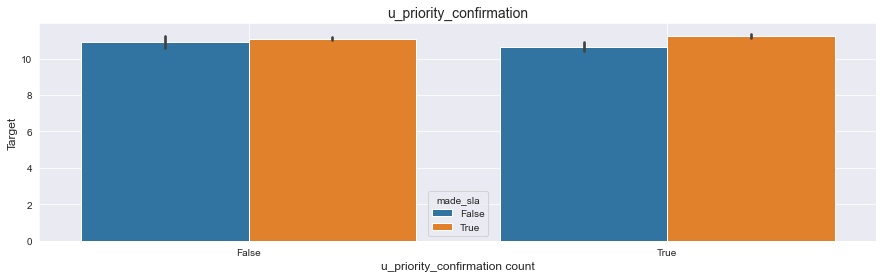

In [29]:
# 'u_priority_confirmation'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'u_priority_confirmation',y='Difference',ax=ax,hue='made_sla')
plt.title("u_priority_confirmation", size = 14)
plt.xlabel("u_priority_confirmation count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

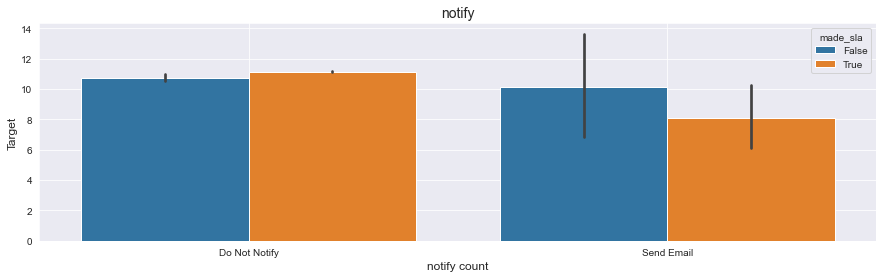

In [30]:
# 'notify'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'notify',y='Difference',ax=ax,hue='made_sla')
plt.title("notify", size = 14)
plt.xlabel("notify count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

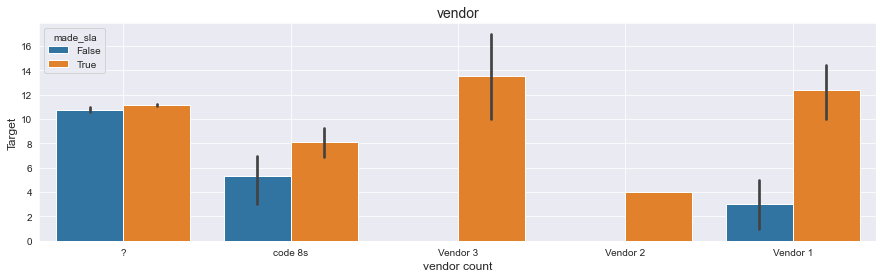

In [35]:
# 'vendor'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'vendor',y='Difference',ax=ax,hue='made_sla')
plt.title("vendor", size = 14)
plt.xlabel("vendor count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

Tickets which does not have Vendor involved, took more time to get closed on average.<br>However for the tickets which took more time to close also is SLA compliant with the help of the Vendor

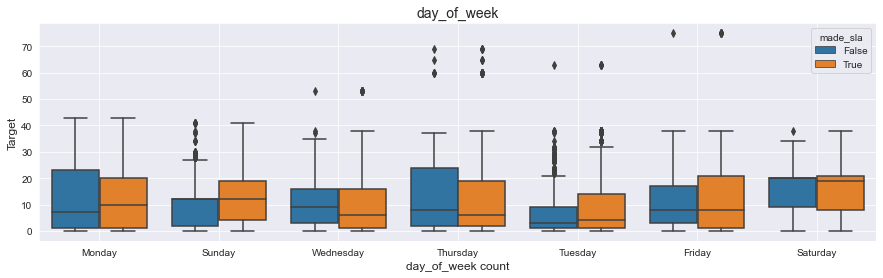

In [40]:
# 'day_of_week'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'day_of_week',y='Difference',ax=ax,hue='made_sla')
plt.title("day_of_week", size = 14)
plt.xlabel("day_of_week count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

As there are no significant overlap, this feature might help us in modeling.

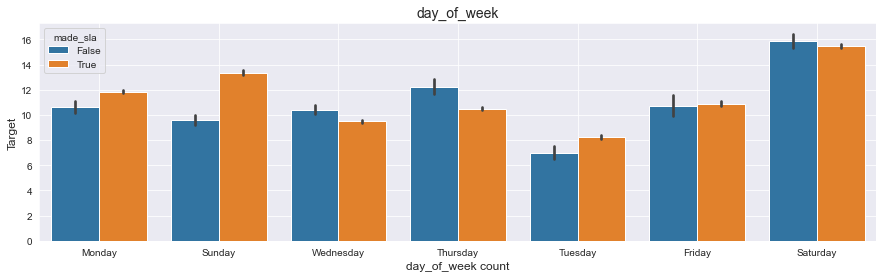

In [42]:
# 'day_of_week'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'day_of_week',y='Difference',ax=ax,hue='made_sla')
plt.title("day_of_week", size = 14)
plt.xlabel("day_of_week count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

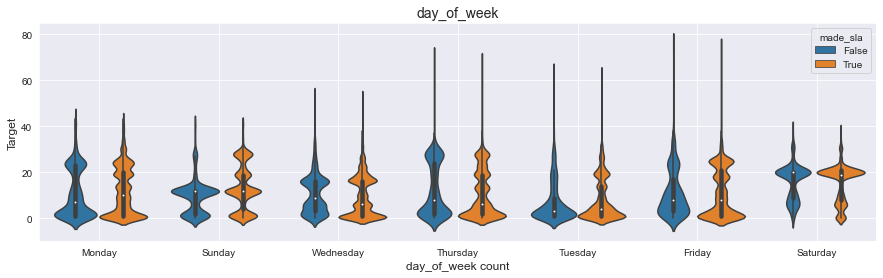

In [46]:
# 'day_of_week'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.violinplot(data=data,x= 'day_of_week',y='Difference',ax=ax,hue='made_sla')
plt.title("day_of_week", size = 14)
plt.xlabel("day_of_week count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

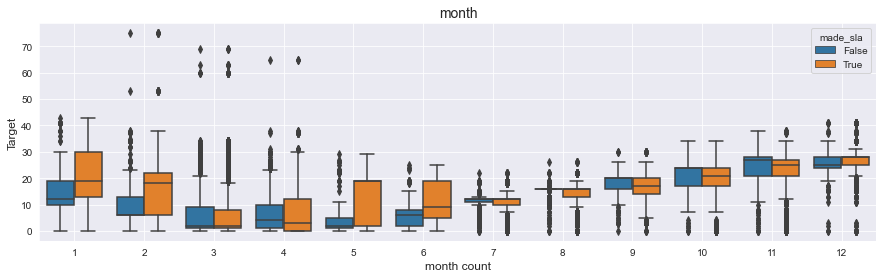

In [41]:
# 'month'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'month',y='Difference',ax=ax,hue='made_sla')
plt.title("month", size = 14)
plt.xlabel("month count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

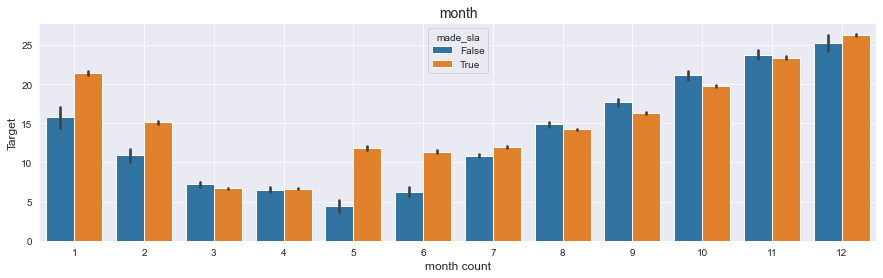

In [43]:
# 'month'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data=data,x= 'month',y='Difference',ax=ax,hue='made_sla')
plt.title("month", size = 14)
plt.xlabel("month count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

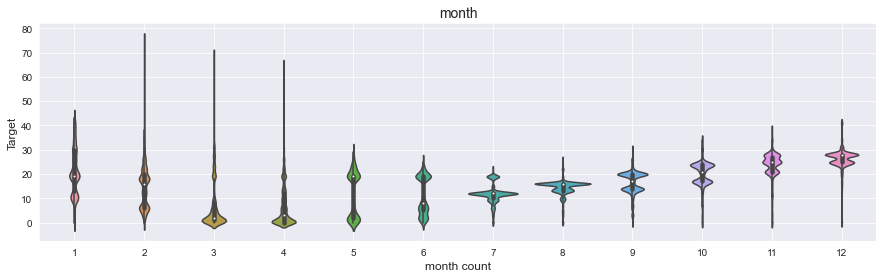

In [45]:
# 'month'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.violinplot(data=data,x= 'month',y='Difference',ax=ax)#,hue='made_sla')
plt.title("month", size = 14)
plt.xlabel("month count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

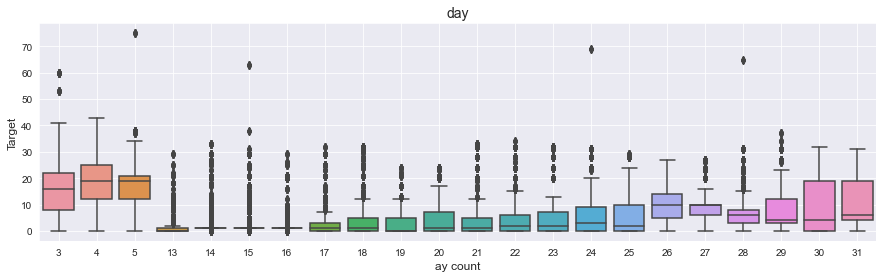

In [51]:
# 'day'
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=data,x= 'day',y='Difference',ax=ax)#,hue='made_sla')
plt.title("day", size = 14)
plt.xlabel("ay count", size=12)
plt.ylabel("Target", size=12)
#plt.xticks(rotation=90)
plt.grid()
plt.show()

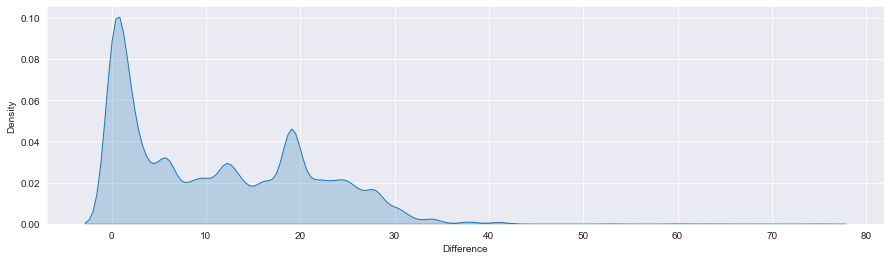

In [82]:
# Lets check the distribution of the dependent variable
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(data['Difference'],fill=True,cmap="mako")
plt.grid()
plt.show()

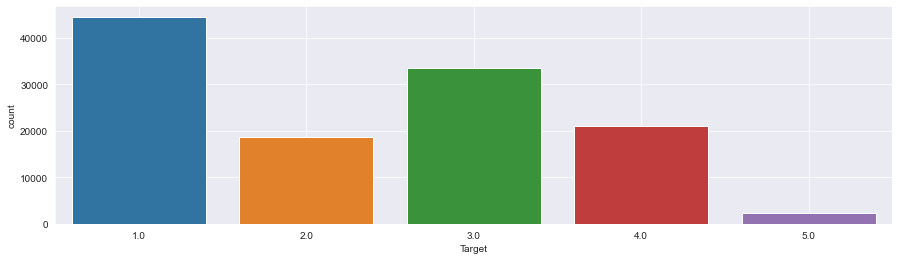

In [83]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Target'])
plt.grid()
plt.show()

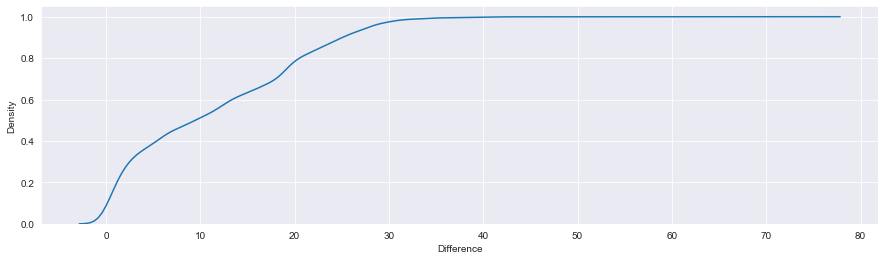

In [85]:
# CDF of the difference
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(data['Difference'],cumulative=True, common_norm=False, common_grid=True)
plt.grid()
plt.show()

At the 'Difference' of <30, almost 99% of data is explained. We need to check more closely into the Outliers

In [100]:
data.Difference.quantile([0.05,.1,0.2 ,.25, .5, .75,.8,.85,.9,.95,.96,.97,.98,.99,1])

0.05     0.0
0.10     0.0
0.20     1.0
0.25     1.0
0.50    10.0
0.75    19.0
0.80    20.0
0.85    23.0
0.90    25.0
0.95    28.0
0.96    28.0
0.97    30.0
0.98    30.0
0.99    34.0
1.00    75.0
Name: Difference, dtype: float64

As seen here from the quantile, there is a steep rise from 0.99 percentile to 1. The rise is more than double.<br>Hence we can consider it to be Outliers and remove data by quantile.<br>Another observation is that, many of the data points have a closure date of zero.

In [101]:
# Removing Outliers 
cols = ['Difference'] # one or more

Q1 = data[cols].quantile(0.1)
Q3 = data[cols].quantile(0.9)
IQR = Q3 - Q1

data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
data.columns

Index(['incident_state', 'active', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'Target', 'day_of_week', 'month', 'day', 'Difference'],
      dtype='object')

In [103]:
data.dtypes

incident_state              object
active                        bool
reassignment_count           int64
reopen_count                 int64
sys_mod_count                int64
made_sla                      bool
opened_by                   object
contact_type                object
location                    object
category                    object
subcategory                 object
u_symptom                   object
impact                      object
urgency                     object
priority                    object
knowledge                     bool
u_priority_confirmation       bool
notify                      object
rfc                         object
vendor                      object
caused_by                   object
Target                     float64
day_of_week                 object
month                        int64
day                          int64
Difference                   int32
dtype: object

In [140]:
def create_conrr(mat):
    sns.set_style("dark")
    #plt.figure(figsize=(14, 10))
    ax = sns.heatmap(mat.corr().round(3), annot=True,cmap="YlGnBu")
    plt.grid()
    plt.title("Numerical Feature Correlation", size = 20)
    plt.show()

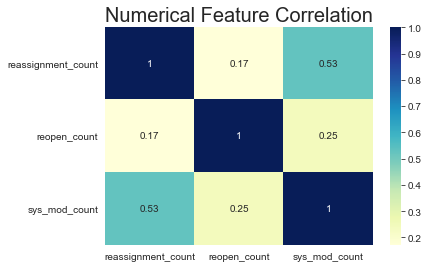

In [141]:
create_conrr(data[num_feat])

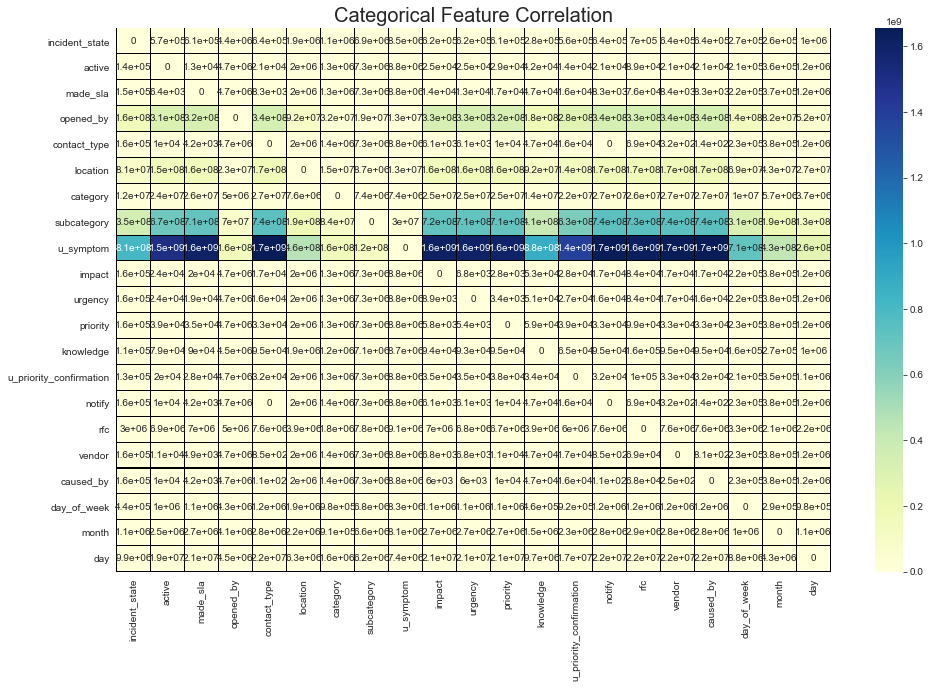

In [145]:
df = data[categorical_feature]

df=df.apply(lambda x : pd.factorize(x)[0])+1

df = pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in df],columns=categorical_feature,index=categorical_feature)
sns.set_style("dark")
plt.figure(figsize=(16, 10))
sns.heatmap(df.round(3), annot=True,cmap="YlGnBu",linecolor='black',linewidths=0.05)
plt.grid()
plt.title("Categorical Feature Correlation", size = 20)
plt.show()

Feature: u_symptom and subcategory comes out as highly Correlated in our Chi-Square test. Hence we can drop those Features

# Modeling

In [104]:
data.columns

Index(['incident_state', 'active', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'Target', 'day_of_week', 'month', 'day', 'Difference'],
      dtype='object')

In [147]:
categorical_feature = ['incident_state', 'active', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'day_of_week', 'month', 'day']
num_feat = ['reassignment_count', 'reopen_count','sys_mod_count']

In [114]:
len(categorical_feature)

21

In [115]:
len(num_feat)

3

In [116]:
data.shape

(119971, 26)

In [148]:
# OneHotEncoding for all the categorical feature
enc = OneHotEncoder(handle_unknown='ignore')
cat_spar = enc.fit_transform(data[categorical_feature])

In [150]:
scaler = StandardScaler()
num_feat = scaler.fit_transform(data[num_feat])

In [3]:
def pandas_to_sparse(mat1,mat2): # Returns combines sparse matrix
    mat2 = csr_matrix(mat2)
    print("End of Sparse Matrix\n")
    return hstack([mat1,mat2])

In [159]:
data_sparse = pandas_to_sparse(cat_spar,num_feat)

End of Sparse Matrix



In [160]:
scipy.sparse.save_npz('data_sparse_1.npz',data_sparse)

In [2]:
data_sparse = scipy.sparse.load_npz('data_sparse_1.npz')
y = pd.read_pickle('y.pkl')

In [4]:
data = pd.read_pickle('data_pick_3.pkl')
data.columns

Index(['incident_state', 'active', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'opened_by', 'contact_type', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'knowledge', 'u_priority_confirmation', 'notify', 'rfc', 'vendor',
       'caused_by', 'Target', 'day_of_week', 'month', 'day', 'Difference'],
      dtype='object')

In [6]:
y = data['Target']
y.to_pickle('y.pkl')

In [9]:
data_sparse.shape

(119971, 649)

In [11]:
y.shape

(119971,)

In [3]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data_sparse, y, test_size=0.33, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [67]:
# This function will provide result to oour classification model
def validate_result(y_true, y_pred,y_prob,model="Model"):
    print(f"The Result for the {model} Classification is a Below\n")
    fig, ax = plt.subplots(figsize=(15,5))
    conf = confusion_matrix(y_true, y_pred).round(3)
    b = sns.heatmap(conf.round(3), cmap="YlGnBu",annot=True,ax = ax)
    b.axes.set_title("Confusion Matrix",fontsize=20)
    b.set_xlabel("Predicted Value",fontsize=16)
    b.set_ylabel("True Value",fontsize=16)
    b.tick_params(labelsize=16)
    print("=="*50)
    print(f"Recall Score: {(recall_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print(f"Precision Score: {(precision_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print("F1 Score: ",f1_score(y_true, y_pred,average='weighted').round(3))
    print("Log Loss: ",log_loss(y_true, y_prob).round(3))
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print("Classification Report:\n",df.round(3))

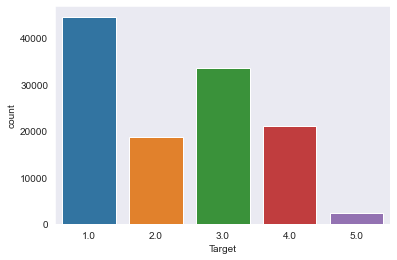

In [31]:
sns.countplot(y)
plt.show()

### Baseline Model

In [18]:
clf = GaussianNB()
clf.fit(X_train.toarray(), y_train)

GaussianNB()

The Result for the GaussianNB Classification is a Below

Recall Score: 13.251 %
Precision Score: 55.821 %
F1 Score:  0.122
Log Loss:  29.804
Classification Report:
               precision  recall  f1-score    support
1.0               0.833   0.025     0.048   9695.000
2.0               0.213   0.329     0.258   4143.000
3.0               0.655   0.049     0.091   7533.000
4.0               0.192   0.232     0.210   4700.000
5.0               0.033   0.998     0.065    455.000
accuracy          0.133   0.133     0.133      0.133
macro avg         0.385   0.326     0.134  26526.000
weighted avg      0.558   0.133     0.122  26526.000


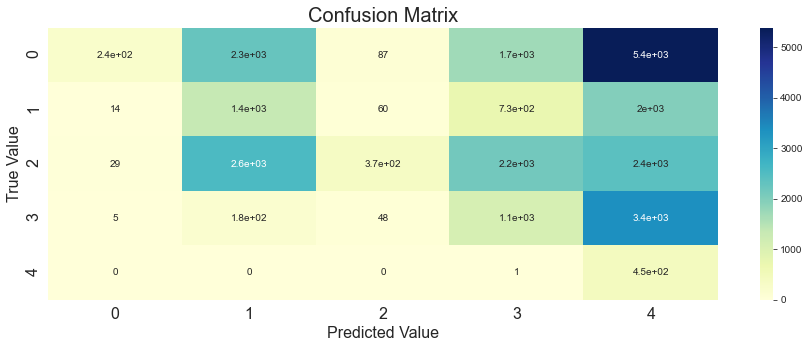

In [29]:
validate_result(y_cv,clf.predict(X_cv.toarray()),clf.predict_proba(X_cv.toarray()),model="GaussianNB")

The Performance of out BaseLine model is very bad. The Class Labels are getting heavily miss classified.

### KNN

In [7]:
param = {'n_neighbors':[3,5,7,9,11,13]}
knn_rand = RandomizedSearchCV(KNeighborsClassifier(),param,verbose=50,return_train_score=True,scoring='f1_macro',cv=3,n_jobs=2)
knn_rand.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 16.8min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed: 17.0min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed: 19.4min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed: 19.6min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed: 22.3min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 22.5min
[Parallel(n

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=2,
                   param_distributions={'n_neighbors': [3, 5, 7, 9, 11, 13]},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [8]:
knn_rand.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [5]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

The Result for the KNN with N=2 Classification is a Below

Recall Score: 82.304 %
Precision Score: 82.264 %
F1 Score:  0.822
Log Loss:  2.24
Classification Report:
               precision  recall  f1-score    support
1.0               0.824   0.910     0.865   9695.000
2.0               0.743   0.695     0.718   4143.000
3.0               0.850   0.817     0.833   7533.000
4.0               0.857   0.790     0.822   4700.000
5.0               0.715   0.591     0.647    455.000
accuracy          0.823   0.823     0.823      0.823
macro avg         0.798   0.760     0.777  26526.000
weighted avg      0.823   0.823     0.822  26526.000


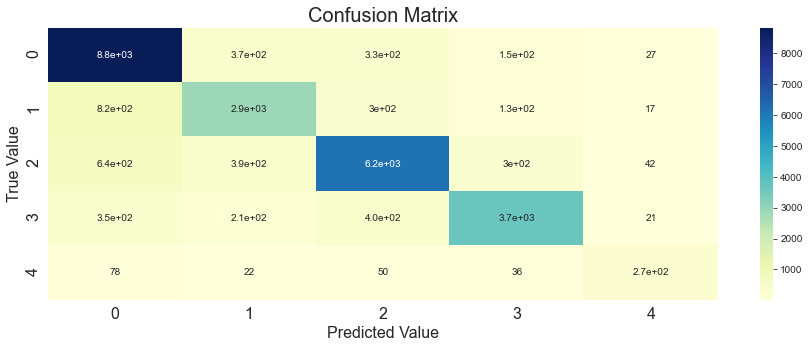

In [6]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model="KNN with N=2")

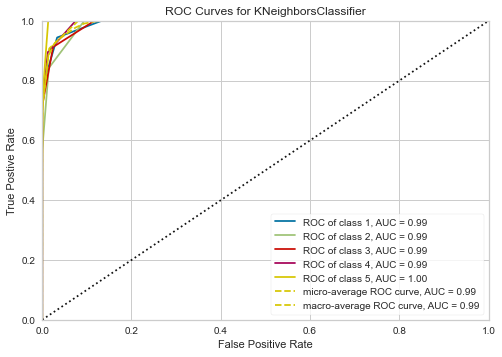

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [7]:
roc_auc(clf,X_train,y_train,X_test = X_cv, y_cv = y_test,classes=[1,2,3,4,5])

We see a massive improvement over our Baseline Model. However we would try to see other models to improve our performance.<br>As the class labels are imbalanced. depending upon the performance we can try sampling our data

### Logistic Regression with SGDClassifier

In [9]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

log_rand = RandomizedSearchCV(SGDClassifier(loss='log',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=3)
log_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   12.8s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   12.9s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   12.9s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   14.6s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   14.8s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   15.0s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:   16.4s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:   16.6s
[Parallel(

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True, loss='log'),
                   n_jobs=3,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [10]:
log_rand.best_score_

0.5428801359233043

In [11]:
log_rand.best_estimator_

SGDClassifier(early_stopping=True, loss='log', penalty='l1')

In [18]:
log_rand.best_params_

{'penalty': 'l1', 'alpha': 0.0001}

In [12]:
clf = SGDClassifier(early_stopping=True, loss='log', penalty='l1')
clf.fit(X_train,y_train)

SGDClassifier(early_stopping=True, loss='log', penalty='l1')

The Result for the Logistic Regression with SGD Classification is a Below

Recall Score: 65.879 %
Precision Score: 64.721 %
F1 Score:  0.628
Log Loss:  0.936
Classification Report:
               precision  recall  f1-score    support
1.0               0.669   0.888     0.763   9695.000
2.0               0.566   0.192     0.287   4143.000
3.0               0.629   0.710     0.667   7533.000
4.0               0.732   0.576     0.645   4700.000
5.0               0.356   0.035     0.064    455.000
accuracy          0.659   0.659     0.659      0.659
macro avg         0.590   0.480     0.485  26526.000
weighted avg      0.647   0.659     0.628  26526.000


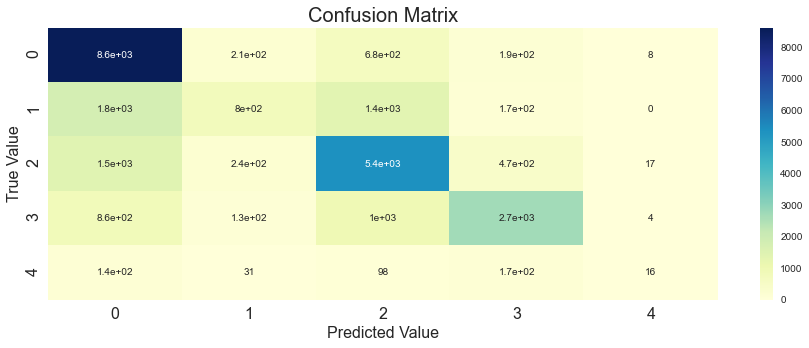

In [13]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Logistic Regression with SGD")

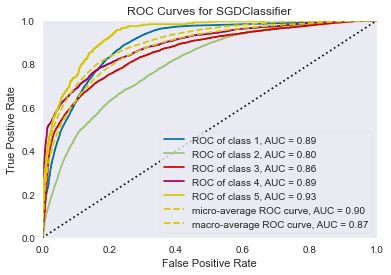

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [15]:
roc_auc(clf,X_train,y_train,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

Logistic Regression performs worse than our KNN Model

### SVM with SGDClassifier

In [19]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

svm_rand = RandomizedSearchCV(SGDClassifier(loss='hinge',early_stopping=True,n_iter_no_change=50),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=3)
svm_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   15.2s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   15.4s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   26.3s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   36.8s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   36.9s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   36.9s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   47.3s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   48.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   48.8s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:   58.6s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:   59.4s
[Parallel(

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True,
                                           n_iter_no_change=50),
                   n_jobs=3,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [20]:
svm_rand.best_score_

0.5315300002383772

In [24]:
svm_rand.best_params_

{'penalty': 'l2', 'alpha': 0.0001}

In [25]:
clf = SGDClassifier(early_stopping=True, n_iter_no_change=50)
clf.fit(X_train,y_train)

SGDClassifier(early_stopping=True, n_iter_no_change=50)

The Result for the SVM with SGD Classification is a Below

Recall Score: 67.161 %
Precision Score: 66.745 %
F1 Score:  0.653
Classification Report:
               precision  recall  f1-score    support
1.0               0.701   0.850     0.768   9695.000
2.0               0.564   0.276     0.370   4143.000
3.0               0.621   0.763     0.685   7533.000
4.0               0.788   0.554     0.651   4700.000
5.0               0.420   0.163     0.235    455.000
accuracy          0.672   0.672     0.672      0.672
macro avg         0.619   0.521     0.542  26526.000
weighted avg      0.667   0.672     0.653  26526.000


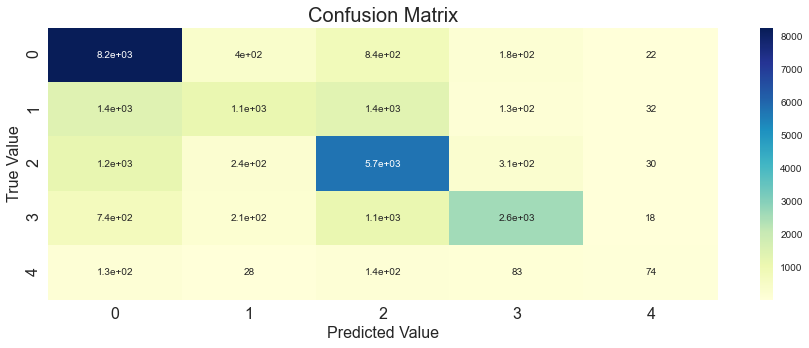

In [30]:
validate_result(y_cv,clf.predict(X_cv),model = "SVM with SGD")

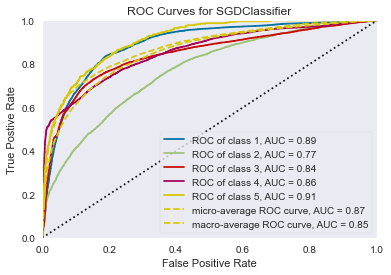

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [31]:
roc_auc(clf,X_train,y_train,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

The SVM is also performing worse than our KNN model

### Random Forest

In [53]:
params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
          "min_samples_leaf": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}
rf_rand = RandomizedSearchCV(RandomForestClassifier(),params,
                              verbose=8,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
rf_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  48 out of  50 | elapsed:  1.4min remaining:    3.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=5,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14]},
                   return_train_score=True, scoring='f1_weighted', verbose=8)

In [54]:
rf_rand.best_score_

0.6406851861679067

In [55]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=14, min_samples_leaf=6)

In [56]:
clf = RandomForestClassifier(max_depth=14, min_samples_leaf=6,n_jobs=5)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=6, n_jobs=5)

The Result for the Random Forest Classification is a Below

Recall Score: 67.055 %
Precision Score: 70.115 %
F1 Score:  0.63
Log Loss:  0.955
Classification Report:
               precision  recall  f1-score    support
1.0               0.628   0.946     0.755   9695.000
2.0               0.715   0.144     0.240   4143.000
3.0               0.674   0.735     0.703   7533.000
4.0               0.867   0.522     0.652   4700.000
5.0               0.880   0.048     0.092    455.000
accuracy          0.671   0.671     0.671      0.671
macro avg         0.753   0.479     0.488  26526.000
weighted avg      0.701   0.671     0.630  26526.000


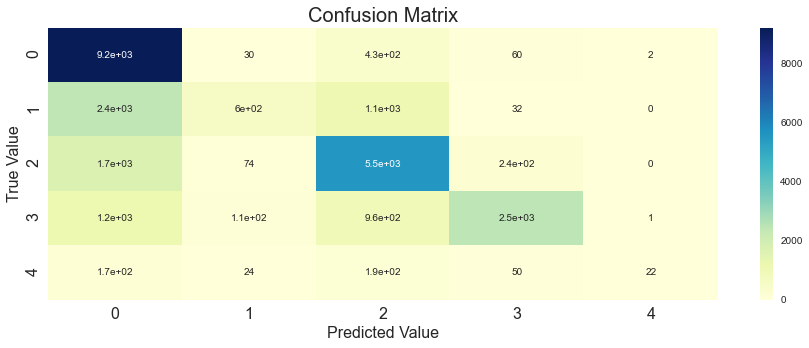

In [57]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Random Forest")

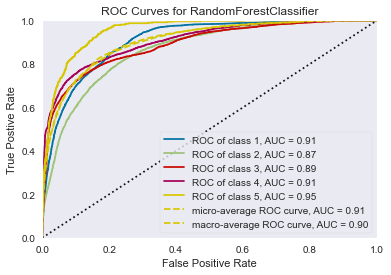

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [58]:
roc_auc(clf,X_train,y_train,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

KNN is as of now performing the best amount all the algorithms

## Sampling

Lets try sampling our data and see the performance of our Model

In [5]:
def sampling_data(X,y,option="SMOTE",strategy = "auto",n_jobs=1):
    if option.lower()=="smote":
        smo = SMOTE(random_state=52,sampling_strategy = strategy,n_jobs=n_jobs)
        smo.fit(X, y)
        X_resampled, y_resampled = smo.fit_sample(X, y)
        return X_resampled,y_resampled
    elif option.lower()=="undersample":
        rus = RandomUnderSampler(random_state=42,sampling_strategy = strategy)
        rus.fit(X, y)
        X_resampled, y_resampled = rus.fit_sample(X, y)
        return X_resampled,y_resampled
    elif option.lower()=="oversample":
        ros = RandomOverSampler(random_state=42,sampling_strategy = strategy)
        ros.fit(X, y)
        X_resampled, y_resampled = ros.fit_sample(X, y)
        return X_resampled,y_resampled
    elif option.lower()=="nearmiss":
        near = NearMiss(sampling_strategy = strategy,n_jobs=n_jobs)
        near.fit(X, y)
        X_resampled, y_resampled = near.fit_sample(X, y)
        return X_resampled,y_resampled
    else:
        print("Please select from the below options: ")
        print("1: Undersample || 2: Oversample || 3: Nearmiss || 4. SMOTE")

### Baseline Model with Sampling

In [71]:
X_sam,y_sam = sampling_data(X_train,y_train,option="nearmiss",strategy = "auto",n_jobs=4)
clf = GaussianNB()
clf.fit(X_sam.toarray(), y_sam)

GaussianNB()

The Result for the GaussianNB with Nearmiss Strategy Classification is a Below

Recall Score: 42.739 %
Precision Score: 47.424 %
F1 Score:  0.44
Log Loss:  18.525
Classification Report:
               precision  recall  f1-score    support
1.0               0.602   0.521     0.559   9695.000
2.0               0.228   0.160     0.188   4143.000
3.0               0.548   0.387     0.453   7533.000
4.0               0.350   0.552     0.429   4700.000
5.0               0.046   0.255     0.078    455.000
accuracy          0.427   0.427     0.427      0.427
macro avg         0.355   0.375     0.341  26526.000
weighted avg      0.474   0.427     0.440  26526.000


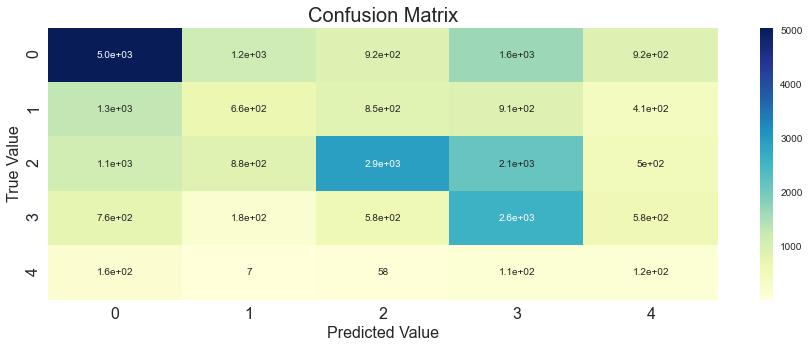

In [72]:
validate_result(y_cv,clf.predict(X_cv.toarray()),clf.predict_proba(X_cv.toarray()),model="GaussianNB with Nearmiss Strategy")

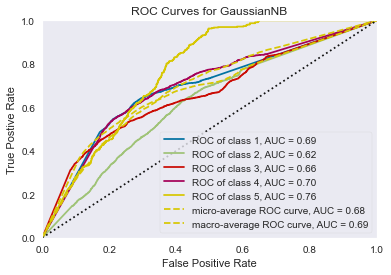

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [74]:
roc_auc(clf,X_sam.toarray(),y_sam,X_test = X_cv.toarray(), y_test = y_cv,classes=[1,2,3,4,5])

The NearMiss Sampling Technique has improved the performance of our model. We would try with other Algorithms as well.

### KNN with NearMiss

In [6]:
X_sam,y_sam = sampling_data(X_train,y_train,option="undersample",strategy = "auto",n_jobs=4)

In [10]:
param = {'n_neighbors':[3,5,7,9,11,13,15]}
knn_rand = RandomizedSearchCV(KNeighborsClassifier(),param,verbose=10,
                              return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=4)
knn_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  32 out of  35 | elapsed:   20.6s remaining:    1.8s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   22.4s finished


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
                   param_distributions={'n_neighbors': [3, 5, 7, 9, 11, 13,
                                                        15]},
                   return_train_score=True, scoring='f1_weighted', verbose=10)

In [14]:
clf = KNeighborsClassifier(n_neighbors=5,n_jobs=4)
clf.fit(X_sam,y_sam)

KNeighborsClassifier(n_jobs=4)

The Result for the KNN with N=5 Classification is a Below

Recall Score: 61.92 %
Precision Score: 68.235 %
F1 Score:  0.641
Log Loss:  4.928
Classification Report:
               precision  recall  f1-score    support
1.0               0.762   0.669     0.713   9695.000
2.0               0.439   0.541     0.485   4143.000
3.0               0.755   0.600     0.669   7533.000
4.0               0.669   0.592     0.628   4700.000
5.0               0.143   0.866     0.246    455.000
accuracy          0.619   0.619     0.619      0.619
macro avg         0.553   0.654     0.548  26526.000
weighted avg      0.682   0.619     0.641  26526.000


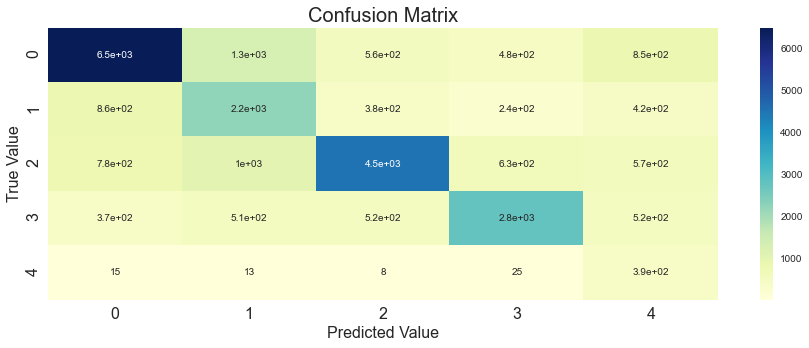

In [15]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model="KNN with N=5")

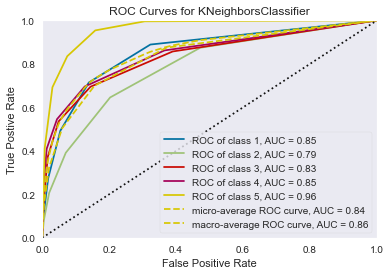

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [16]:
roc_auc(clf,X_sam,y_sam,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

The Performance of the non-sampled data is far better

### Logistic Regression with SGD and Sampling

#### Undersampling

In [17]:
X_sam,y_sam = sampling_data(X_train,y_train,option="undersample",strategy = "auto",n_jobs=4)

In [18]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

log_rand = RandomizedSearchCV(SGDClassifier(loss='log',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=4)
log_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1310s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapse

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True, loss='log'),
                   n_jobs=4,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [19]:
log_rand.best_estimator_

SGDClassifier(alpha=0.001, early_stopping=True, loss='log', penalty='l1')

In [20]:
log_rand.best_score_

0.6134401650902307

In [22]:
clf = SGDClassifier(alpha=0.001, early_stopping=True, loss='log', penalty='l1',n_jobs=4)
clf.fit(X_sam,y_sam)

SGDClassifier(alpha=0.001, early_stopping=True, loss='log', n_jobs=4,
              penalty='l1')

The Result for the Logistic Regression with SGD and UnderSampling Classification is a Below

Recall Score: 58.886 %
Precision Score: 67.424 %
F1 Score:  0.621
Log Loss:  1.118
Classification Report:
               precision  recall  f1-score    support
1.0               0.775   0.657     0.711   9695.000
2.0               0.432   0.482     0.456   4143.000
3.0               0.725   0.549     0.625   7533.000
4.0               0.653   0.586     0.618   4700.000
5.0               0.097   0.809     0.174    455.000
accuracy          0.589   0.589     0.589      0.589
macro avg         0.537   0.616     0.517  26526.000
weighted avg      0.674   0.589     0.621  26526.000


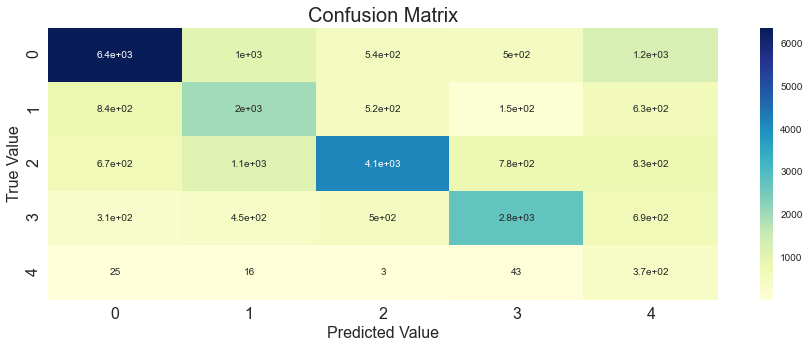

In [23]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Logistic Regression with SGD and UnderSampling")

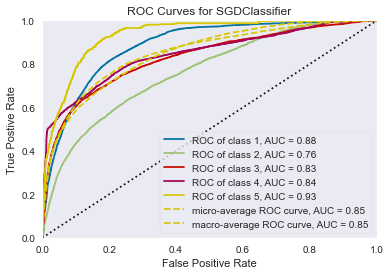

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [24]:
roc_auc(clf,X_train,y_train,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

#### NearMiss

In [25]:
X_sam,y_sam = sampling_data(X_train,y_train,option="nearmiss",strategy = "auto",n_jobs=4)

In [26]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

log_rand = RandomizedSearchCV(SGDClassifier(loss='log',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=4)
log_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1312s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapse

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True, loss='log'),
                   n_jobs=4,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [27]:
log_rand.best_estimator_

SGDClassifier(alpha=0.01, early_stopping=True, loss='log')

In [28]:
log_rand.best_score_

0.5261542586638324

In [29]:
clf = SGDClassifier(alpha=0.01, early_stopping=True, loss='log',n_jobs=4)
clf.fit(X_sam,y_sam)

SGDClassifier(alpha=0.01, early_stopping=True, loss='log', n_jobs=4)

The Result for the Logistic Regression with SGD and NearMiss Classification is a Below

Recall Score: 32.297 %
Precision Score: 49.796 %
F1 Score:  0.365
Log Loss:  1.625
Classification Report:
               precision  recall  f1-score    support
1.0               0.748   0.323     0.451   9695.000
2.0               0.182   0.251     0.211   4143.000
3.0               0.508   0.290     0.369   7533.000
4.0               0.289   0.420     0.342   4700.000
5.0               0.043   0.519     0.079    455.000
accuracy          0.323   0.323     0.323      0.323
macro avg         0.354   0.361     0.291  26526.000
weighted avg      0.498   0.323     0.365  26526.000


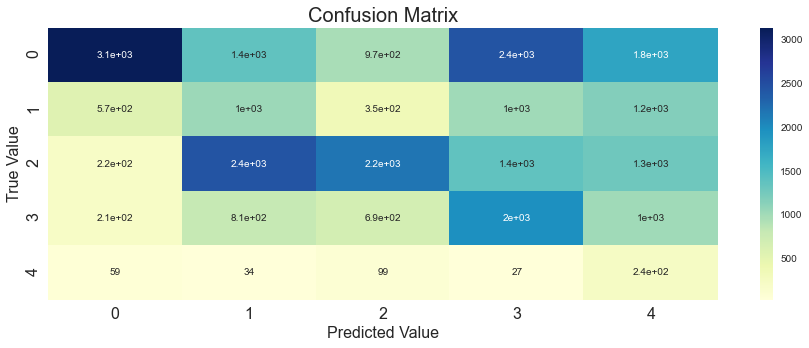

In [30]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Logistic Regression with SGD and NearMiss")

#### OverSampling

In [32]:
X_sam,y_sam = sampling_data(X_train,y_train,option="Oversample",strategy = "auto",n_jobs=4)

In [33]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

log_rand = RandomizedSearchCV(SGDClassifier(loss='log',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=4)
log_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    7.3s
[Parallel(

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True, loss='log'),
                   n_jobs=4,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [34]:
log_rand.best_estimator_

SGDClassifier(early_stopping=True, loss='log')

In [35]:
log_rand.best_params_

{'penalty': 'l2', 'alpha': 0.0001}

In [36]:
log_rand.best_score_

0.640898376108544

In [37]:
clf = SGDClassifier(alpha=0.0001, early_stopping=True, loss='log',n_jobs=4)
clf.fit(X_sam,y_sam)

SGDClassifier(early_stopping=True, loss='log', n_jobs=4)

The Result for the Logistic Regression with SGD and Oversample Classification is a Below

Recall Score: 64.182 %
Precision Score: 68.73 %
F1 Score:  0.649
Log Loss:  0.988
Classification Report:
               precision  recall  f1-score    support
1.0               0.688   0.848     0.760   9695.000
2.0               0.488   0.404     0.442   4143.000
3.0               0.771   0.549     0.642   7533.000
4.0               0.780   0.560     0.652   4700.000
5.0               0.149   0.782     0.250    455.000
accuracy          0.642   0.642     0.642      0.642
macro avg         0.575   0.629     0.549  26526.000
weighted avg      0.687   0.642     0.649  26526.000


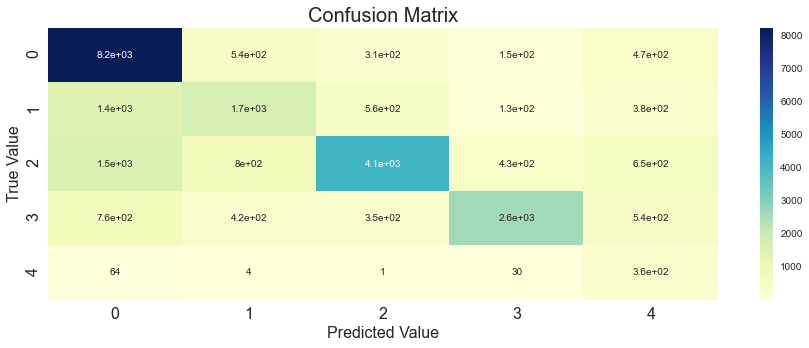

In [38]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Logistic Regression with SGD and Oversample")

The F1-Score did  not get better than our native KNN model.<br> However has decreased significantly. 

### SVM with SGD and Sampling

#### UnderSampling

In [39]:
X_sam,y_sam = sampling_data(X_train,y_train,option="undersample",strategy = "auto",n_jobs=4)

In [42]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

svm_rand = RandomizedSearchCV(SGDClassifier(loss='hinge',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=4)
svm_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1250s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapse

RandomizedSearchCV(cv=5, estimator=SGDClassifier(early_stopping=True), n_jobs=4,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_weighted', verbose=50)

In [43]:
svm_rand.best_score_

0.60796783298856

In [44]:
svm_rand.best_params_

{'penalty': 'l1', 'alpha': 0.001}

In [45]:
svm_rand.best_estimator_

SGDClassifier(alpha=0.001, early_stopping=True, penalty='l1')

In [46]:
clf = SGDClassifier(alpha=0.001, early_stopping=True, penalty='l1',n_jobs=4)
clf.fit(X_sam,y_sam)

SGDClassifier(alpha=0.001, early_stopping=True, n_jobs=4, penalty='l1')

The Result for the SVM with SGD and Undersampling Classification is a Below

Recall Score: 61.973 %
Precision Score: 64.733 %
F1 Score:  0.628
Classification Report:
               precision  recall  f1-score   support
1.0               0.719   0.760     0.739   9695.00
2.0               0.468   0.366     0.410   4143.00
3.0               0.674   0.598     0.633   7533.00
4.0               0.664   0.580     0.619   4700.00
5.0               0.145   0.716     0.241    455.00
accuracy          0.620   0.620     0.620      0.62
macro avg         0.534   0.604     0.529  26526.00
weighted avg      0.647   0.620     0.628  26526.00


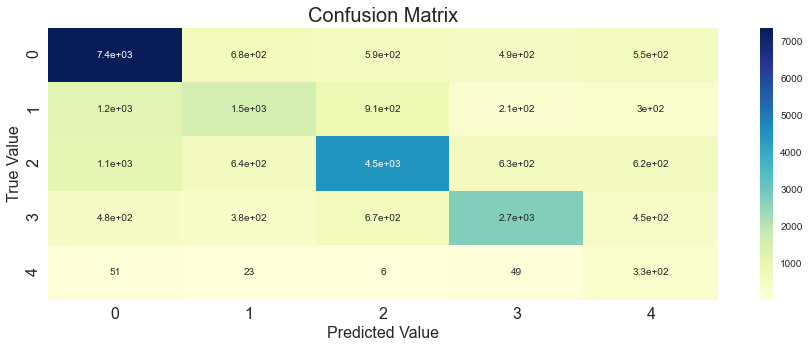

In [49]:
validate_result(y_cv,clf.predict(X_cv),model = "SVM with SGD and Undersampling")

#### NearMiss

In [50]:
X_sam,y_sam = sampling_data(X_train,y_train,option="nearmiss",strategy = "auto",n_jobs=4)

In [51]:
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

svm_rand = RandomizedSearchCV(SGDClassifier(loss='hinge',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=4)
svm_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(

RandomizedSearchCV(cv=5, estimator=SGDClassifier(early_stopping=True), n_jobs=4,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_weighted', verbose=50)

In [53]:
svm_rand.best_estimator_

SGDClassifier(alpha=0.01, early_stopping=True)

In [54]:
clf = SGDClassifier(alpha=0.01, early_stopping=True,n_jobs=4)
clf.fit(X_sam,y_sam)

SGDClassifier(alpha=0.01, early_stopping=True, n_jobs=4)

The Result for the SVM with SGD and NearMiss Classification is a Below

Recall Score: 31.403 %
Precision Score: 50.272 %
F1 Score:  0.342
Classification Report:
               precision  recall  f1-score    support
1.0               0.795   0.242     0.372   9695.000
2.0               0.205   0.342     0.257   4143.000
3.0               0.413   0.267     0.324   7533.000
4.0               0.350   0.494     0.410   4700.000
5.0               0.045   0.505     0.082    455.000
accuracy          0.314   0.314     0.314      0.314
macro avg         0.362   0.370     0.289  26526.000
weighted avg      0.503   0.314     0.342  26526.000


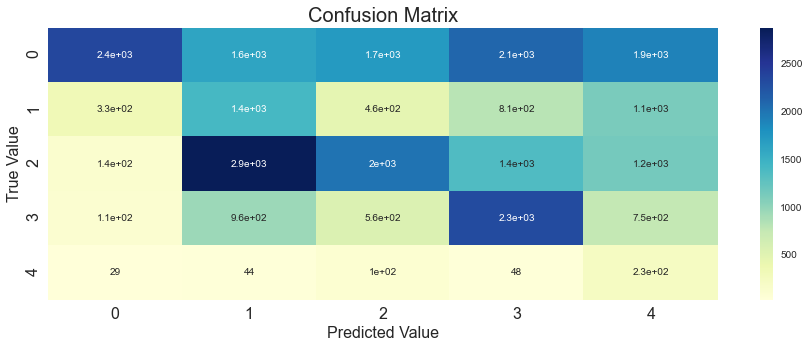

In [55]:
validate_result(y_cv,clf.predict(X_cv),model = "SVM with SGD and NearMiss")

#### OverSampling

In [56]:
X_sam,y_sam = sampling_data(X_train,y_train,option="oversample",strategy = "auto",n_jobs=4)

In [57]:
param = {'alpha': [1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

svm_rand = RandomizedSearchCV(SGDClassifier(loss='hinge',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=4)
svm_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    6.8s
[Parallel(

RandomizedSearchCV(cv=5, estimator=SGDClassifier(early_stopping=True), n_jobs=4,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 1.0, 10.0, 100.0,
                                                  1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_weighted', verbose=50)

In [58]:
svm_rand.best_score_

0.644597241020412

In [60]:
svm_rand.best_estimator_

SGDClassifier(early_stopping=True, penalty='l1')

In [61]:
clf = SGDClassifier(penalty='l1',early_stopping=True,n_jobs=4)
clf.fit(X_sam,y_sam)

SGDClassifier(early_stopping=True, n_jobs=4, penalty='l1')

The Result for the SVM with SGD and Oversample Classification is a Below

Recall Score: 61.487 %
Precision Score: 67.892 %
F1 Score:  0.636
Classification Report:
               precision  recall  f1-score    support
1.0               0.753   0.710     0.731   9695.000
2.0               0.468   0.384     0.422   4143.000
3.0               0.647   0.656     0.651   7533.000
4.0               0.819   0.530     0.644   4700.000
5.0               0.121   0.875     0.213    455.000
accuracy          0.615   0.615     0.615      0.615
macro avg         0.561   0.631     0.532  26526.000
weighted avg      0.679   0.615     0.636  26526.000


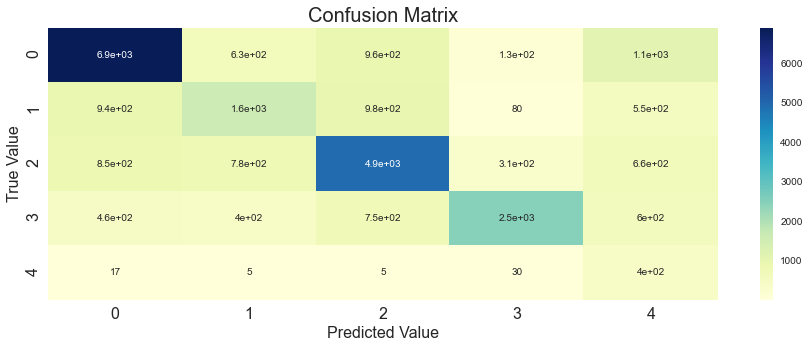

In [62]:
validate_result(y_cv,clf.predict(X_cv),model = "SVM with SGD and Oversample")

### RandomForest with Sampling

#### UnderSample

In [63]:
X_sam,y_sam = sampling_data(X_train,y_train,option="undersample",strategy = "auto",n_jobs=4)

In [64]:
params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
          "min_samples_leaf": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}
rf_rand = RandomizedSearchCV(RandomForestClassifier(),params,
                              verbose=8,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
rf_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done  48 out of  50 | elapsed:   10.3s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   10.4s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=5,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14]},
                   return_train_score=True, scoring='f1_weighted', verbose=8)

In [65]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=14, min_samples_leaf=7)

In [66]:
rf_rand.best_score_

0.6375236512640313

In [68]:
clf = RandomForestClassifier(max_depth=14, min_samples_leaf=7,n_jobs=5)
clf.fit(X_sam,y_sam)

RandomForestClassifier(max_depth=14, min_samples_leaf=7, n_jobs=5)

The Result for the Random Forest with UnderSampling Classification is a Below

Recall Score: 65.355 %
Precision Score: 68.787 %
F1 Score:  0.664
Log Loss:  1.184
Classification Report:
               precision  recall  f1-score    support
1.0               0.731   0.782     0.755   9695.000
2.0               0.493   0.518     0.505   4143.000
3.0               0.729   0.606     0.662   7533.000
4.0               0.758   0.586     0.661   4700.000
5.0               0.155   0.646     0.249    455.000
accuracy          0.654   0.654     0.654      0.654
macro avg         0.573   0.627     0.566  26526.000
weighted avg      0.688   0.654     0.664  26526.000


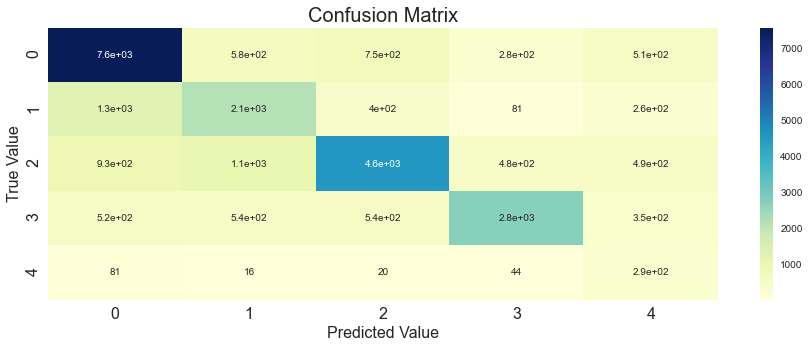

In [69]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Random Forest with UnderSampling")

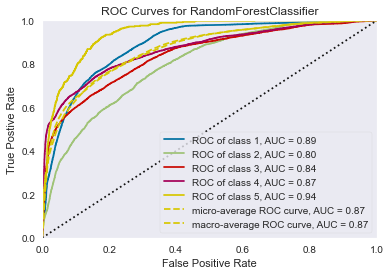

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [73]:
roc_auc(clf,X_sam,y_sam,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

#### NearMiss

In [74]:
X_sam,y_sam = sampling_data(X_train,y_train,option="nearmiss",strategy = "auto",n_jobs=4)

In [75]:
params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
          "min_samples_leaf": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}
rf_rand = RandomizedSearchCV(RandomForestClassifier(),params,
                              verbose=8,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
rf_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done  48 out of  50 | elapsed:   10.0s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   10.2s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=5,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14]},
                   return_train_score=True, scoring='f1_weighted', verbose=8)

In [76]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=3)

In [77]:
clf = RandomForestClassifier(max_depth=9, min_samples_leaf=3,n_jobs=5)
clf.fit(X_sam,y_sam)

RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_jobs=5)

The Result for the Random Forest with NearMiss Classification is a Below

Recall Score: 33.771 %
Precision Score: 51.566 %
F1 Score:  0.396
Log Loss:  1.525
Classification Report:
               precision  recall  f1-score    support
1.0               0.714   0.388     0.503   9695.000
2.0               0.234   0.241     0.238   4143.000
3.0               0.523   0.292     0.375   7533.000
4.0               0.389   0.376     0.383   4700.000
5.0               0.027   0.486     0.051    455.000
accuracy          0.338   0.338     0.338      0.338
macro avg         0.378   0.357     0.310  26526.000
weighted avg      0.516   0.338     0.396  26526.000


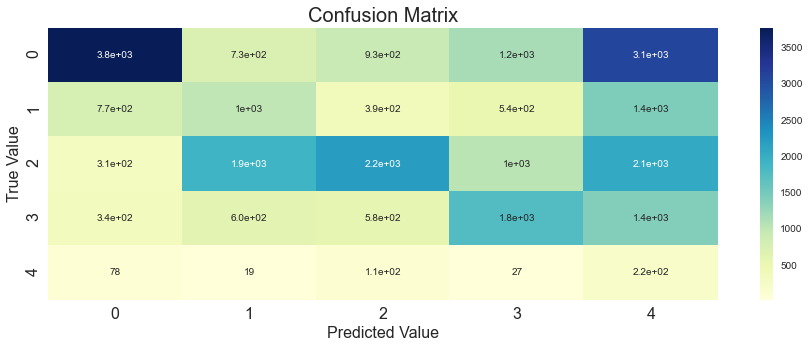

In [78]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Random Forest with NearMiss")

#### OverSampling

In [79]:
X_sam,y_sam = sampling_data(X_train,y_train,option="oversample",strategy = "auto",n_jobs=4)

In [80]:
params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
          "min_samples_leaf": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}
rf_rand = RandomizedSearchCV(RandomForestClassifier(),params,
                              verbose=8,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
rf_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   31.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done  48 out of  50 | elapsed:  2.2min remaining:    5.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=5,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14]},
                   return_train_score=True, scoring='f1_weighted', verbose=8)

In [82]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=13, min_samples_leaf=9)

In [83]:
clf = RandomForestClassifier(max_depth=13, min_samples_leaf=9,n_jobs=5)
clf.fit(X_sam,y_sam)

RandomForestClassifier(max_depth=13, min_samples_leaf=9, n_jobs=5)

The Result for the Random Forest with OverSample Classification is a Below

Recall Score: 69.377 %
Precision Score: 72.668 %
F1 Score:  0.702
Log Loss:  1.118
Classification Report:
               precision  recall  f1-score    support
1.0               0.736   0.825     0.778   9695.000
2.0               0.572   0.550     0.561   4143.000
3.0               0.815   0.633     0.713   7533.000
4.0               0.754   0.642     0.694   4700.000
5.0               0.184   0.738     0.295    455.000
accuracy          0.694   0.694     0.694      0.694
macro avg         0.612   0.678     0.608  26526.000
weighted avg      0.727   0.694     0.702  26526.000


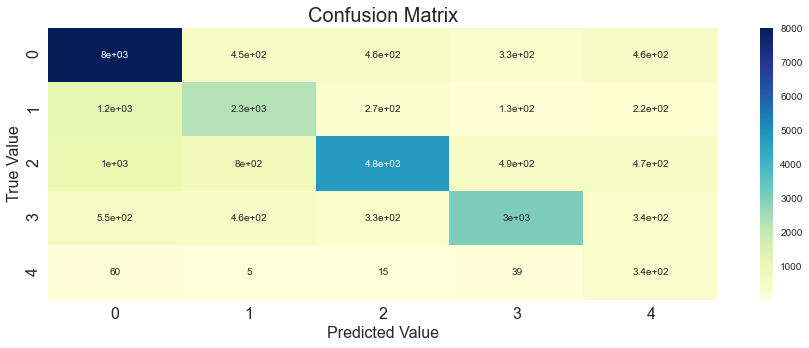

In [84]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model = "Random Forest with OverSample")

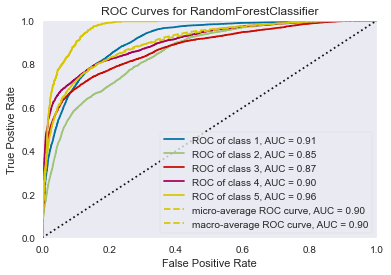

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [88]:
roc_auc(clf,X_sam,y_sam,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

## XGBoost Classifier

In [98]:
params = {"learning_rate" : [0.00001,0.0001,0.001,0.01,0.1,1,10,100] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'subsample':[0.6, 0.7, 0.8, 0.9]}
xgb_rand = RandomizedSearchCV(XGBClassifier(),params,
                              verbose=100,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
xgb_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   15.9s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   16.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:   16.2s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:   16.3s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:   33.6s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:   33.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:   34.3s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:   34.5s
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:   59.2s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:   59.6s
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           verbosity=None),
                   n_jobs=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                

In [99]:
xgb_rand.best_score_

0.6758660156117988

In [105]:
xgb_rand.best_params_

{'subsample': 0.6,
 'reg_alpha': 1,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.0001,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [100]:
xgb_rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0001, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0001, max_delta_step=0, max_depth=8,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0001, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

The Result for the XGBClassifier Classification is a Below

Recall Score: 69.879 %
Precision Score: 71.366 %
F1 Score:  0.673
Log Loss:  1.601
Classification Report:
               precision  recall  f1-score    support
1.0               0.659   0.938     0.774   9695.000
2.0               0.711   0.278     0.400   4143.000
3.0               0.711   0.741     0.726   7533.000
4.0               0.830   0.569     0.676   4700.000
5.0               0.725   0.064     0.117    455.000
accuracy          0.699   0.699     0.699      0.699
macro avg         0.727   0.518     0.539  26526.000
weighted avg      0.714   0.699     0.673  26526.000


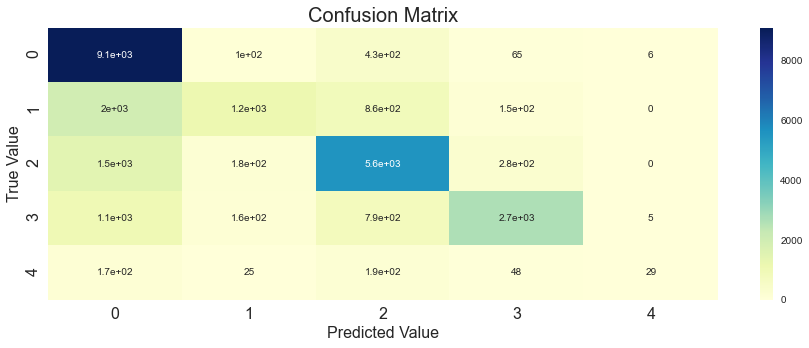

In [104]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model="XGBClassifier")

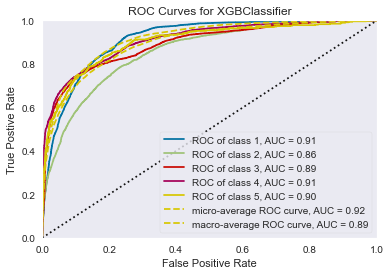

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [106]:
roc_auc(clf,X_train,y_train,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5])

We get the best AUC Score with XGBoost, however the F1 Score did not did not improve.

### XGBoost with Sampling

#### UnderSample

In [107]:
X_sam,y_sam = sampling_data(X_train,y_train,option="undersample",strategy = "auto",n_jobs=4)

In [108]:
params = {"learning_rate" : [0.00001,0.0001,0.001,0.01,0.1,1,10,100] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'subsample':[0.6, 0.7, 0.8, 0.9]}
xgb_rand = RandomizedSearchCV(XGBClassifier(),params,
                              verbose=10,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
xgb_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   14.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:   25.9s remaining:    1.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   26.2s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           verbosity=None),
                   n_jobs=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                

In [109]:
xgb_rand.best_score_

0.7142971676815264

In [110]:
xgb_rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf.fit(X_sam,y_sam)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

The Result for the XGBClassifier UnderSampled Classification is a Below

Recall Score: 68.996 %
Precision Score: 74.184 %
F1 Score:  0.707
Log Loss:  0.847
Classification Report:
               precision  recall  f1-score   support
1.0               0.806   0.756     0.780   9695.00
2.0               0.510   0.631     0.564   4143.00
3.0               0.827   0.653     0.730   7533.00
4.0               0.732   0.646     0.687   4700.00
5.0               0.183   0.888     0.303    455.00
accuracy          0.690   0.690     0.690      0.69
macro avg         0.612   0.715     0.613  26526.00
weighted avg      0.742   0.690     0.707  26526.00


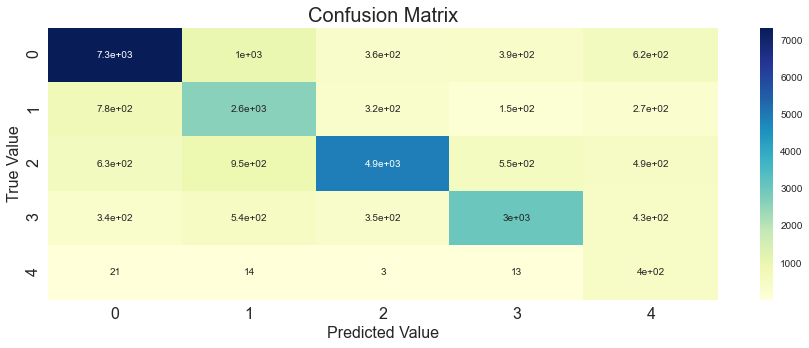

In [113]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model="XGBClassifier UnderSampled")

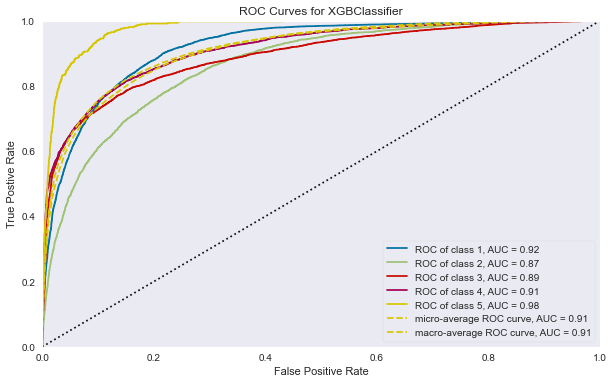

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [118]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
roc_auc(clf,X_sam,y_sam,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5],ax=ax)

#### NearMiss

In [119]:
X_sam,y_sam = sampling_data(X_train,y_train,option="nearmiss",strategy = "auto",n_jobs=4)

In [120]:
params = {"learning_rate" : [0.00001,0.0001,0.001,0.01,0.1,1,10,100] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'subsample':[0.6, 0.7, 0.8, 0.9]}
xgb_rand = RandomizedSearchCV(XGBClassifier(),params,
                              verbose=10,return_train_score=True,scoring='f1_weighted',cv=5,n_jobs=5)
xgb_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   12.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   15.9s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:   26.6s remaining:    1.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   27.0s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           verbosity=None),
                   n_jobs=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                

In [121]:
xgb_rand.best_score_

0.5541865934249414

In [122]:
xgb_rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.01,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=7, monotone_constraints='()',
              n_estimators=100, n_jobs=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.01,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf.fit(X_sam,y_sam)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.01,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

The Result for the XGBClassifier NearMiss Classification is a Below

Recall Score: 34.182 %
Precision Score: 54.982 %
F1 Score:  0.38
Log Loss:  1.593
Classification Report:
               precision  recall  f1-score    support
1.0               0.757   0.357     0.485   9695.000
2.0               0.225   0.447     0.299   4143.000
3.0               0.603   0.198     0.298   7533.000
4.0               0.371   0.418     0.393   4700.000
5.0               0.049   0.646     0.092    455.000
accuracy          0.342   0.342     0.342      0.342
macro avg         0.401   0.413     0.314  26526.000
weighted avg      0.550   0.342     0.380  26526.000


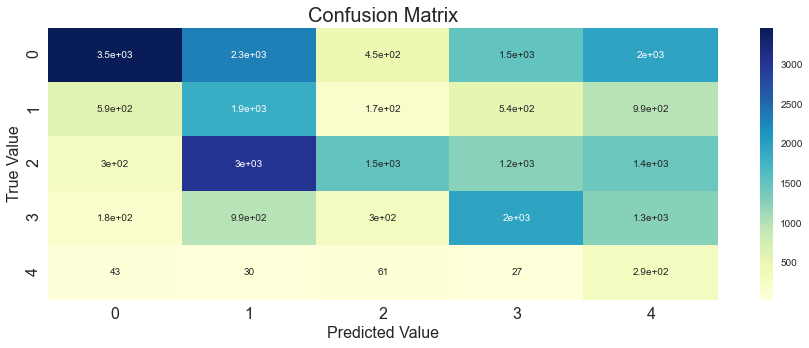

In [124]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model="XGBClassifier NearMiss")

#### OverSample

In [125]:
X_sam,y_sam = sampling_data(X_train,y_train,option="oversample",strategy = "auto",n_jobs=4)

In [126]:
params = {"learning_rate" : [0.00001,0.0001,0.001,0.01,0.1,1,10,100] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'subsample':[0.6, 0.7, 0.8, 0.9]}
xgb_rand = RandomizedSearchCV(XGBClassifier(),params,
                              verbose=10,scoring='f1_weighted',cv=5,n_jobs=5)
xgb_rand.fit(X_sam,y_sam)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   22.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   46.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:  7.5min remaining:   28.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  7.6min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_jobs=5,
                   para

In [127]:
xgb_rand.best_score_

0.7464443976345716

In [129]:
xgb_rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [130]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf.fit(X_sam,y_sam)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

The Result for the XGBClassifier OverSample Classification is a Below

Recall Score: 72.518 %
Precision Score: 74.994 %
F1 Score:  0.731
Log Loss:  1.545
Classification Report:
               precision  recall  f1-score    support
1.0               0.768   0.840     0.802   9695.000
2.0               0.584   0.598     0.591   4143.000
3.0               0.836   0.668     0.742   7533.000
4.0               0.770   0.683     0.724   4700.000
5.0               0.252   0.826     0.386    455.000
accuracy          0.725   0.725     0.725      0.725
macro avg         0.642   0.723     0.649  26526.000
weighted avg      0.750   0.725     0.731  26526.000


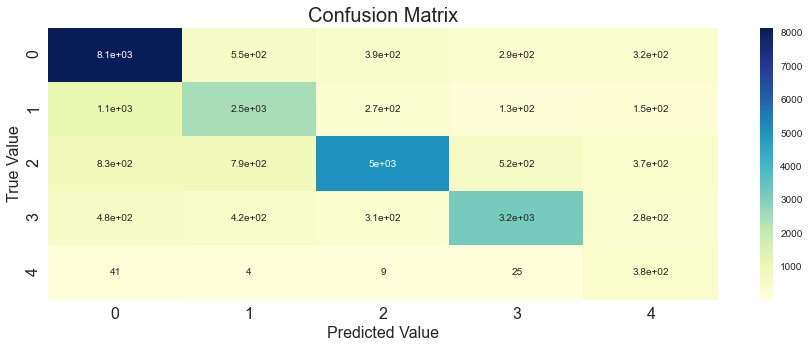

In [131]:
validate_result(y_cv,clf.predict(X_cv),clf.predict_proba(X_cv),model="XGBClassifier OverSample")

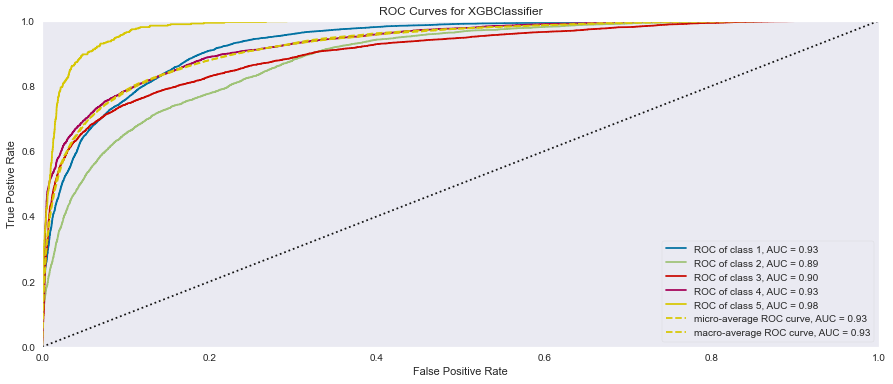

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [133]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
roc_auc(clf,X_sam,y_sam,X_test = X_cv, y_test = y_cv,classes=[1,2,3,4,5],ax=ax)

# KNN Test Results

In [134]:
X_train, X_test, y_train, y_test = train_test_split(data_sparse, y, test_size=0.33, random_state=42)

In [138]:
clf = KNeighborsClassifier(n_neighbors=3,n_jobs=3)
clf.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=3, n_neighbors=3)

The Result for the KNN with N=3 Classification is a Below

Recall Score: 85.517 %
Precision Score: 85.481 %
F1 Score:  0.854
Log Loss:  1.888
Classification Report:
               precision  recall  f1-score    support
1.0               0.861   0.926     0.893  14815.000
2.0               0.791   0.758     0.774   6146.000
3.0               0.867   0.853     0.860  11000.000
4.0               0.883   0.816     0.848   6887.000
5.0               0.806   0.639     0.713    743.000
accuracy          0.855   0.855     0.855      0.855
macro avg         0.842   0.798     0.818  39591.000
weighted avg      0.855   0.855     0.854  39591.000


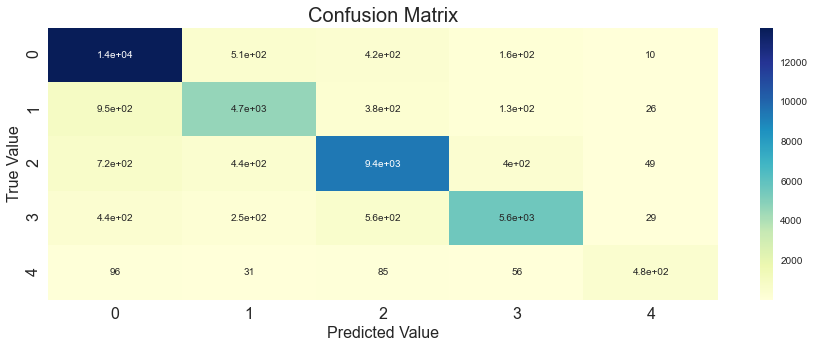

In [139]:
validate_result(y_test,clf.predict(X_test),clf.predict_proba(X_test),model="KNN with N=3")

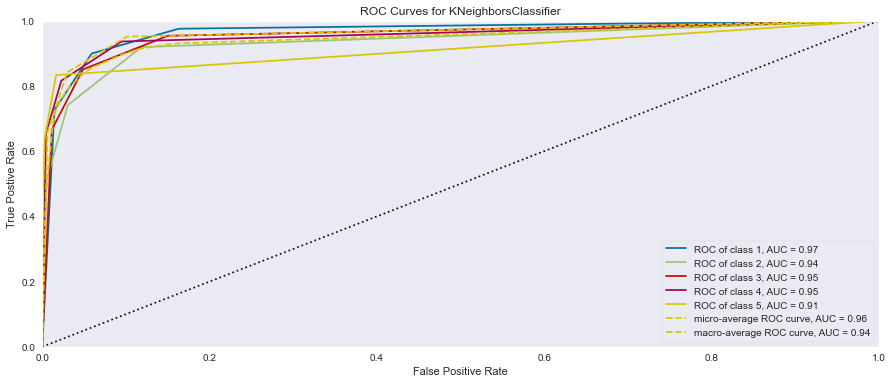

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [141]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[1,2,3,4,5],ax=ax)

# We are getting F1 Score on our Test data = 0.85.<br> AUC Score on all the Class Labels are above 0.90.<br> Also Precision and Recall are also above 0.85.

Since we do not have any text data about the issue it is difficult to get a higher score with only the details on the Incident, instead details of the Issue.

# Multi Layer Perceptron

In [144]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=200,learning_rate='adaptive',early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=20,
                    verbose=True)
clf.fit(X_train,y_train)

Iteration 1, loss = 0.95425618
Validation score: 0.691134
Iteration 2, loss = 0.75818827
Validation score: 0.725595
Iteration 3, loss = 0.67949891
Validation score: 0.745044
Iteration 4, loss = 0.62823676
Validation score: 0.759434
Iteration 5, loss = 0.58740709
Validation score: 0.768889
Iteration 6, loss = 0.55509314
Validation score: 0.775981
Iteration 7, loss = 0.52616938
Validation score: 0.787261
Iteration 8, loss = 0.49987632
Validation score: 0.795057
Iteration 9, loss = 0.47593146
Validation score: 0.801277
Iteration 10, loss = 0.45396279
Validation score: 0.807664
Iteration 11, loss = 0.43263945
Validation score: 0.818612
Iteration 12, loss = 0.41602904
Validation score: 0.823298
Iteration 13, loss = 0.39689925
Validation score: 0.828938
Iteration 14, loss = 0.38090940
Validation score: 0.832172
Iteration 15, loss = 0.36574101
Validation score: 0.835324
Iteration 16, loss = 0.35211482
Validation score: 0.841254
Iteration 17, loss = 0.33835656
Validation score: 0.842374
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=200,
              learning_rate='adaptive', n_iter_no_change=20,
              validation_fraction=0.3, verbose=True)

The Result for the MLP Classification is a Below

Recall Score: 90.99 %
Precision Score: 90.968 %
F1 Score:  0.91
Log Loss:  0.283
Classification Report:
               precision  recall  f1-score   support
1.0               0.919   0.956     0.937  14815.00
2.0               0.887   0.842     0.864   6146.00
3.0               0.913   0.903     0.908  11000.00
4.0               0.915   0.890     0.902   6887.00
5.0               0.811   0.838     0.825    743.00
accuracy          0.910   0.910     0.910      0.91
macro avg         0.889   0.886     0.887  39591.00
weighted avg      0.910   0.910     0.910  39591.00


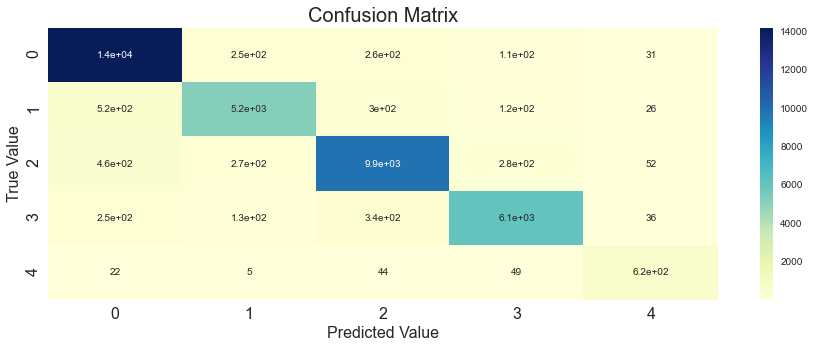

In [145]:
validate_result(y_test,clf.predict(X_test),clf.predict_proba(X_test),model="MLP")

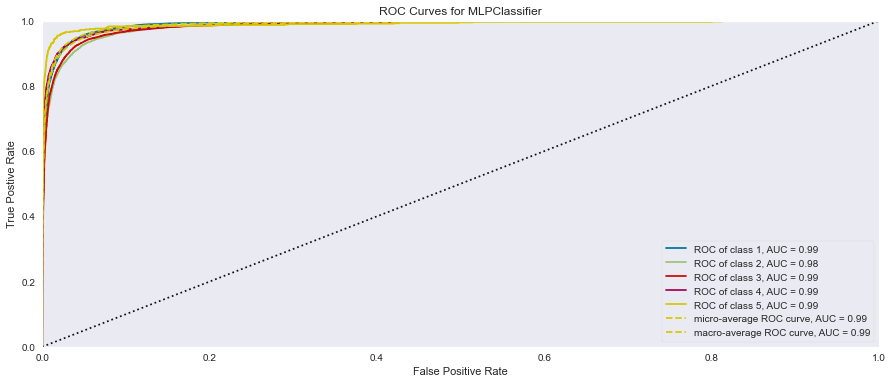

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [146]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[1,2,3,4,5],ax=ax)

In [147]:
clf = MLPClassifier(hidden_layer_sizes=400,learning_rate='adaptive',early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=20,
                    verbose=True)
clf.fit(X_train,y_train)

Iteration 1, loss = 0.91922802
Validation score: 0.703077
Iteration 2, loss = 0.71985344
Validation score: 0.745086
Iteration 3, loss = 0.63742708
Validation score: 0.767770
Iteration 4, loss = 0.57938777
Validation score: 0.783901
Iteration 5, loss = 0.52878960
Validation score: 0.789168
Iteration 6, loss = 0.48733717
Validation score: 0.806046
Iteration 7, loss = 0.44949272
Validation score: 0.820644
Iteration 8, loss = 0.41911960
Validation score: 0.827486
Iteration 9, loss = 0.38927390
Validation score: 0.835158
Iteration 10, loss = 0.36440458
Validation score: 0.844903
Iteration 11, loss = 0.34273195
Validation score: 0.848802
Iteration 12, loss = 0.32106862
Validation score: 0.856971
Iteration 13, loss = 0.30192734
Validation score: 0.860537
Iteration 14, loss = 0.28701395
Validation score: 0.869039
Iteration 15, loss = 0.27319187
Validation score: 0.864270
Iteration 16, loss = 0.25807573
Validation score: 0.870324
Iteration 17, loss = 0.24617088
Validation score: 0.874762
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=400,
              learning_rate='adaptive', n_iter_no_change=20,
              validation_fraction=0.3, verbose=True)

The Result for the MLP Classification is a Below

Recall Score: 91.857 %
Precision Score: 91.885 %
F1 Score:  0.919
Log Loss:  0.306
Classification Report:
               precision  recall  f1-score    support
1.0               0.947   0.945     0.946  14815.000
2.0               0.863   0.892     0.877   6146.000
3.0               0.911   0.916     0.913  11000.000
4.0               0.926   0.903     0.914   6887.000
5.0               0.878   0.791     0.832    743.000
accuracy          0.919   0.919     0.919      0.919
macro avg         0.905   0.889     0.897  39591.000
weighted avg      0.919   0.919     0.919  39591.000


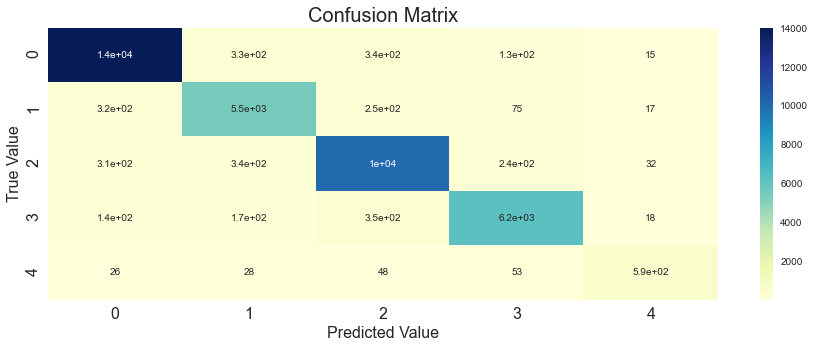

In [148]:
validate_result(y_test,clf.predict(X_test),clf.predict_proba(X_test),model="MLP")

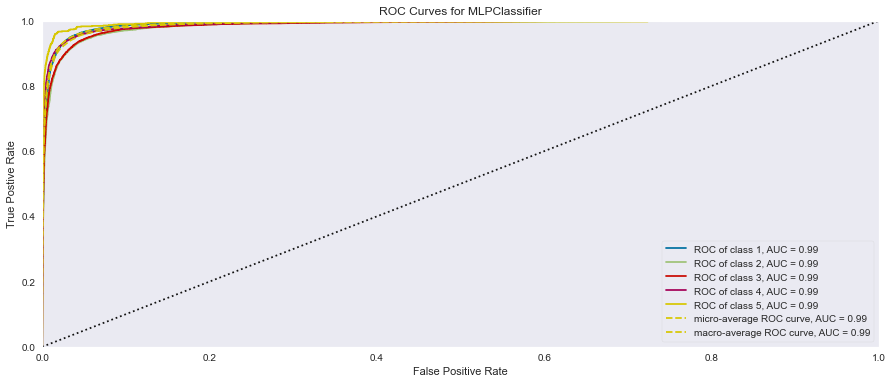

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[1, 2, 3, 4, 5], model=None)

In [149]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
roc_auc(clf,X_train,y_train,X_test = X_test, y_test = y_test,classes=[1,2,3,4,5],ax=ax)

# Neural Network gives us the best results.